### Imports

In [1]:
pip install pandas seaborn scipy torch scikit-learn pytorch_forecasting pytorch_lightning lightgbm xgboost statsmodels optuna plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 33.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 37.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 60.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 39.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [73]:
# -------------------------------------------
# Imports & notebook housekeeping
# -------------------------------------------

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------------------------
from datetime import datetime
import itertools
import calendar as cal                   # weekday / month names
import scipy.stats as stats              # normality, skew, etc.
from scipy import stats as sc_stats


# -------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import lightgbm as lgb                   # gradient boosting (fast baseline)
import xgboost as xgb                    # alternative GBM
# import prophet                          # uncomment if you want fbprophet
import statsmodels.api as sm            # ARIMA, ETS, SARIMAX, etc.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
import optuna

# -------------------------------------------
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from pytorch_forecasting.models import NBeats

import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import Callback

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint


# -------------------------------------
import plotly.express as px              # interactive EDA
import plotly.graph_objects as go

# -------------------------------------------
# Reproducibility
SEED = 42
np.random.seed(SEED)

# -------------------------------------------
# Nice-to-have settings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")          # comment out if you prefer default
# # keep this line by itself if you want explicit inline plotting
# %matplotlib inline

# -------------------------------------------
# Wider, higher-res plots for Matplotlib
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 110

In [3]:
# -------------------------------------------
# File locations
# -------------------------------------------]

DATA_PATH = Path("data")            # adjust if our folder is elsewhere

train_path      = DATA_PATH / "train.csv"
calendar_path   = DATA_PATH / "calendar_events.csv"
submission_path = DATA_PATH / "forecast_submission.csv"

### Loading the existing data

In [4]:
# -------------------------------------------
# Load raw CSVs
# -------------------------------------------
train_df    = pd.read_csv(train_path,    parse_dates=["date"])
calendar_df = pd.read_csv(calendar_path, parse_dates=["date"])
test_df     = pd.read_csv(submission_path)   # 'id' encodes date

# Deduplicate (defensive; raw file *should* be clean)
dup_cnt = train_df.duplicated(subset=["store_id", "date"]).sum()
if dup_cnt:
    print(f"⚠️  Found {dup_cnt:,} duplicate store-day rows – aggregating.")
    train_df = (train_df
                .groupby(["store_id", "date"], as_index=False, sort=True)
                .agg({"revenue": "sum"}))

print("Train shape after dedup :", train_df.shape)
display(train_df)
display(calendar_df)
display(test_df)


# -------------------------------------------
# Merge calendar ‘event’ + helper columns
# -------------------------------------------
full_df = (
    train_df.merge(calendar_df, on="date", how="left")      # adds `event`
            .assign(
                dow         = lambda d: d.date.dt.dayofweek,   # 0=Mon … 6=Sun
                month       = lambda d: d.date.dt.month,
                is_zero_day = lambda d: (d.revenue == 0).astype(int)
            )
)

# -------------------------------------------
# Build ±3-day window flags (wide pivot, NO extra rows)
# -------------------------------------------
# create lead/lag columns in the calendar table
cal_shift = calendar_df.copy()
for k in range(1, 4):
    cal_shift[f'event_lead{k}'] = cal_shift['event'].shift(-k)   # k days BEFORE
    cal_shift[f'event_lag{k}']  = cal_shift['event'].shift( k)   # k days AFTER

# pivot so each offset is its own column -> still 1 row per date
lead_lag_cols = [c for c in cal_shift.columns if 'lead' in c or 'lag' in c]
cal_wide = cal_shift[['date'] + lead_lag_cols]

# merge (still one row per date)
full_df = full_df.merge(cal_wide, on="date", how="left")

print("Full DF shape :", full_df.shape)        # should still be 18 766 × (…)
print("Unique (store,date) pairs:", full_df[['store_id','date']].duplicated().sum())
display(full_df)


# -------------------------------------------
# Persist snapshot for all downstream work
# -------------------------------------------
out_path = DATA_PATH / "full_train.pkl"
full_df.to_pickle(out_path)
print(f"✅  Saved merged & enriched train to {out_path}")

Train shape after dedup : (18766, 4)


,store_id,store_name,date,revenue
0,0,All Stores,2011-01-29,204126.52
1,0,All Stores,2011-01-30,197426.42
2,0,All Stores,2011-01-31,144267.27
3,0,All Stores,2011-02-01,151903.00
4,0,All Stores,2011-02-02,117399.88
...,...,...,...,...
18761,10,Wisconsin – Badger Crossing,2015-09-26,25689.55
18762,10,Wisconsin – Badger Crossing,2015-09-27,26557.53
18763,10,Wisconsin – Badger Crossing,2015-09-28,19067.53
18764,10,Wisconsin – Badger Crossing,2015-09-29,16467.95


,date,event
0,2011-02-06,SuperBowl
1,2011-02-14,ValentinesDay
2,2011-02-21,PresidentsDay
3,2011-03-09,LentStart
4,2011-03-16,LentWeek2
...,...,...
157,2016-05-08,Mother's day
158,2016-05-30,MemorialDay
159,2016-06-02,NBAFinalsStart
160,2016-06-07,Ramadan starts


,id,prediction
0,0_20151001,0
1,0_20151002,0
2,0_20151003,0
3,0_20151004,0
4,0_20151005,0
...,...,...
1007,10_20151227,0
1008,10_20151228,0
1009,10_20151229,0
1010,10_20151230,0


Full DF shape : (18766, 14)
Unique (store,date) pairs: 0


,store_id,store_name,date,revenue,event,dow,month,is_zero_day,event_lead1,event_lag1,event_lead2,event_lag2,event_lead3,event_lag3
0,0,All Stores,2011-01-29,204126.52,NaN,5,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,All Stores,2011-01-30,197426.42,NaN,6,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,All Stores,2011-01-31,144267.27,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,All Stores,2011-02-01,151903.00,NaN,1,2,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,All Stores,2011-02-02,117399.88,NaN,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18761,10,Wisconsin – Badger Crossing,2015-09-26,25689.55,NaN,5,9,0,NaN,NaN,NaN,NaN,NaN,NaN
18762,10,Wisconsin – Badger Crossing,2015-09-27,26557.53,NaN,6,9,0,NaN,NaN,NaN,NaN,NaN,NaN
18763,10,Wisconsin – Badger Crossing,2015-09-28,19067.53,NaN,0,9,0,NaN,NaN,NaN,NaN,NaN,NaN
18764,10,Wisconsin – Badger Crossing,2015-09-29,16467.95,NaN,1,9,0,NaN,NaN,NaN,NaN,NaN,NaN


✅  Saved merged & enriched train to data/full_train.pkl


In [5]:
# Helper function to make a Kaggle submission file
def make_submission(preds, template_path="data/forecast_submission.csv",
                    out_path="my_submission.csv"):
    """
    Put predictions into exact Kaggle format and save the CSV.
    Assumes `preds` are in the **same order** as rows in the template.
    """
    template = pd.read_csv(template_path)
    if len(preds) != len(template):
        raise ValueError(f"Row-count mismatch: {len(preds)=}, "
                         f"{len(template)=}")
    sub = template.copy()
    sub["prediction"] = np.asarray(preds).ravel()
    sub.to_csv(out_path, index=False)
    print(f"✅  Saved {out_path}  ({len(sub):,} rows)")
    return sub

### Understand the Data & Hierarchy

In [6]:
# unique store ids
print("Store IDs:", sorted(train_df.store_id.unique()))

Store IDs: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]


In [7]:
# aggregate consistency check (check if all stores revenues are correct according to the sum of all independent stores)
total_vs_sum = (
    train_df.query("store_id == 0")
            .set_index("date")["revenue"]
    - train_df.query("store_id != 0")
             .groupby("date")["revenue"].sum()
)
print("Max absolute diff agg vs sum:", total_vs_sum.abs().max())

Max absolute diff agg vs sum: 0.03999999997904524


In [8]:
# date continuity gaps (checks for missing dates in each store)
gaps = {}
for sid, grp in train_df.groupby("store_id"):
    # focus on the revenue Series only
    has_gap = (
        grp.set_index("date")["revenue"]   # <-- pick the column
           .asfreq("D")
           .isna()
           .any()                          # now a single bool
    )
    if has_gap:
        gaps[sid] = grp

print("Stores with gaps:", list(gaps.keys()))

Stores with gaps: []


In [9]:
# number of days with exact 0 revenue
zero_ratio = (
    train_df.assign(is_zero = lambda d: d.revenue == 0)
            .groupby("store_id").is_zero.mean()
            .mul(100).round(2)
)
display(zero_ratio.to_frame("pct_zero_days"))

,pct_zero_days
store_id,
0,0.00
1,0.23
2,0.00
3,0.06
4,0.23
5,0.18
6,0.12
7,0.00
8,0.18


In [10]:
# check when each store start and end date
span = train_df.groupby("store_id").date.agg(['min','max'])
display(span)

,min,max
store_id,,
0,2011-01-29,2015-09-30
1,2011-01-29,2015-09-30
2,2011-01-29,2015-09-30
3,2011-01-29,2015-09-30
4,2011-01-29,2015-09-30
5,2011-01-29,2015-09-30
6,2011-01-29,2015-09-30
7,2011-01-29,2015-09-30
8,2011-01-29,2015-09-30


In [11]:
# Leap-year row check
for sid in full_df.store_id.unique():
    assert pd.Timestamp('2012-02-29') in full_df.query("store_id==@sid").date.values

### Data exploration

####  Daily revenue lines, faceted by store_id

**Take-aways**

Trend: every store shows a roughly monotonic rise—good evidence of macro growth.

Weekly pulses: the saw-tooth pattern hints at a strong weekday/weekend cycle.

Data gaps/outliers: vertical drops to (almost) zero on identical dates across stores—likely system outages or missing-data days; we should flag or impute them.

Scale differences: store 0 dwarfs the others, confirming it’s the aggregate series (see Q&A at bottom).


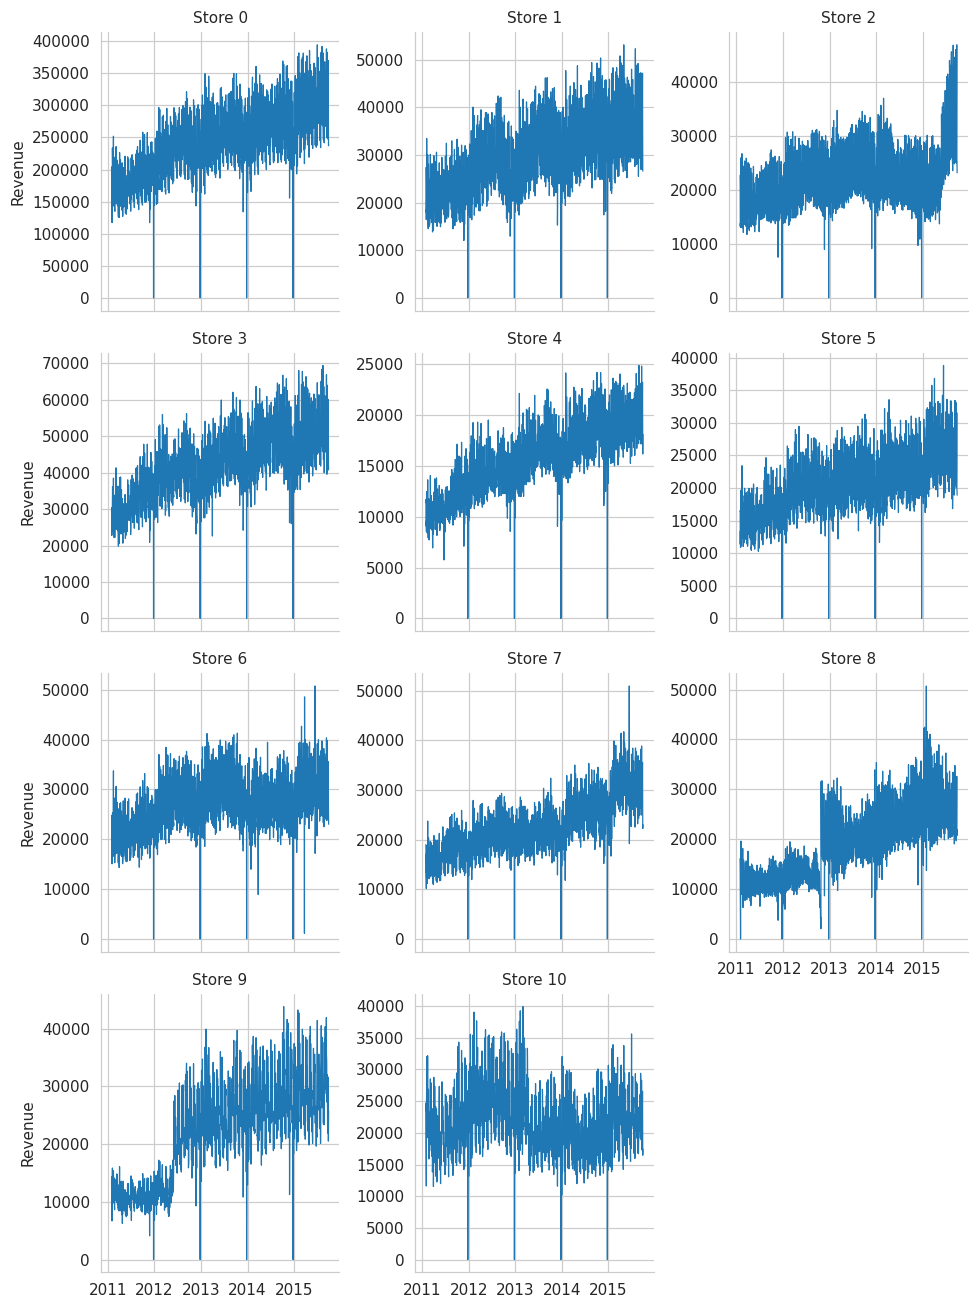

In [12]:
# -----------------------------------------------------------
# Daily revenue lines, faceted by store_id
# -----------------------------------------------------------

g = sns.FacetGrid(
    data=train_df,
    col="store_id",
    col_wrap=3,        # 3 columns per row
    height=3,
    sharey=False
)
g.map_dataframe(sns.lineplot, x="date", y="revenue", lw=0.8)
g.set_titles("Store {col_name}")
g.set_axis_labels("", "Revenue")
plt.tight_layout()
plt.show()

#### 30-day moving average vs. raw daily series (example: store 0)

**Take-aways**

* needs to expect all the stores to be present, not just store 0

Structural trend: 30-day MA climbs from ~180 k → 310 k, confirming long-term growth.

Seasonal bumps: gentle yearly waves (likely Q4 holiday lift).

Extreme troughs: the periodic near-zero spikes match the outages seen above—helps decide outlier handling.


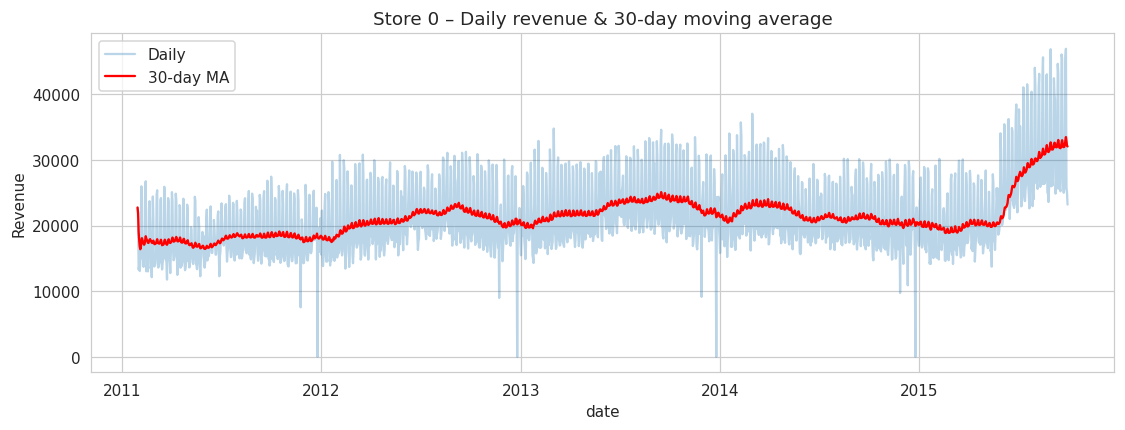

In [13]:
# -----------------------------------------------------------
# Moving average overlay for the "all-stores" series (store_id 0)
# -----------------------------------------------------------
store0 = (
    train_df.loc[train_df.store_id == 2]
            .sort_values("date")
            .assign(ma_30=lambda d: d.revenue.rolling(30, min_periods=1).mean())
)

plt.figure(figsize=(12,4))
sns.lineplot(data=store0, x="date", y="revenue", alpha=0.3, label="Daily")
sns.lineplot(data=store0, x="date", y="ma_30",        color="red", label="30-day MA")
plt.title("Store 0 – Daily revenue & 30-day moving average")
plt.ylabel("Revenue")
plt.show()

#### Weekday pattern (all stores combined)

**Take-aways**

Weekend premium: Sat/Sun medians roughly 25 % higher than mid-week.

Friday build-up: Friday sits between weekdays and weekends—useful for lag features.

Monday rebound: Monday median still higher than Tue–Thu—interesting after-weekend catch-up.

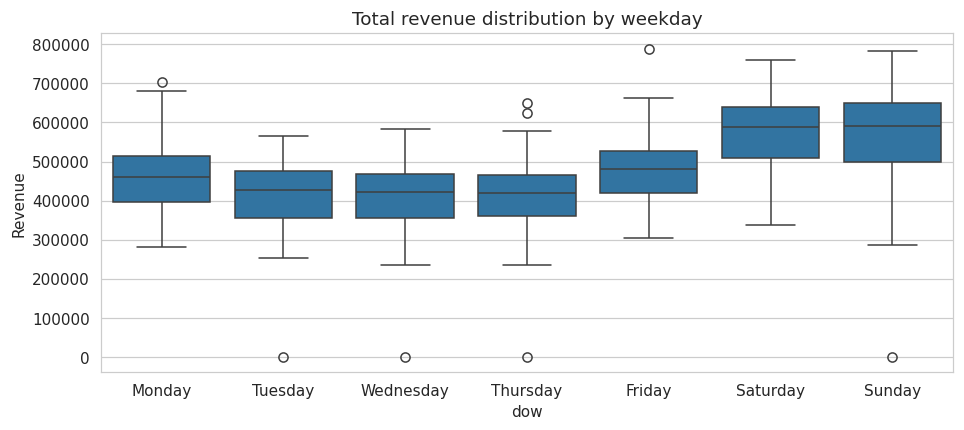

In [14]:
# -----------------------------------------------------------
# Box-plot by day-of-week
# -----------------------------------------------------------
weekday_df = (
    train_df.assign(dow=train_df.date.dt.day_name())
            .groupby(["dow", "date"]).revenue.sum().reset_index()  # total across stores
)
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

plt.figure(figsize=(10,4))
sns.boxplot(data=weekday_df, x="dow", y="revenue", order=order)
plt.title("Total revenue distribution by weekday")
plt.ylabel("Revenue")
plt.show()

#### Month-over-month total revenue (stacked by store)

**Take-aways**

Growth slope: aggregate monthly revenue ~doubles over 5 years, confirms non-stationarity.

Store mix stability: colour bands keep their thickness ~constant → stores grow proportionally; no single store overtakes others (apart from store 0’s built-in dominance).

Holiday peak: one large spike Q4-2013; cross-check with calendar_events.


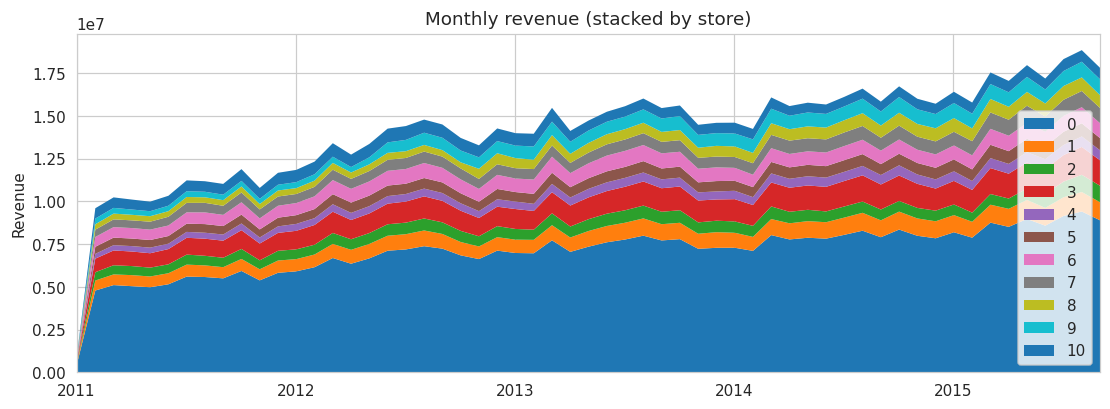

In [15]:
# -----------------------------------------------------------
# Monthly totals pivoted wide → stacked area chart
# -----------------------------------------------------------
monthly_totals = (
    train_df.assign(ym=train_df.date.dt.to_period("M"))
            .groupby(["ym", "store_id"]).revenue.sum()
            .unstack("store_id")
            .rename_axis(index=None, columns=None)
)
monthly_totals.index = monthly_totals.index.to_timestamp()  # Period → Timestamp

monthly_totals.plot.area(figsize=(12,4), stacked=True, linewidth=0)
plt.title("Monthly revenue (stacked by store)")
plt.ylabel("Revenue")
plt.show()

#### Holiday / special-event impact scatter

**Take-aways**

* not too understandable plot needs to be addapted

Positive lift: most coloured markers sit high above the daily baseline—events ≈ sales boosters.

Event variance: some events cluster lower, meaning not every holiday helps (e.g., minor state holidays).

Missing labels: a few natural peaks lack an event tag—maybe promo periods worth creating custom flags for (e.g., “Back-to-School” week).


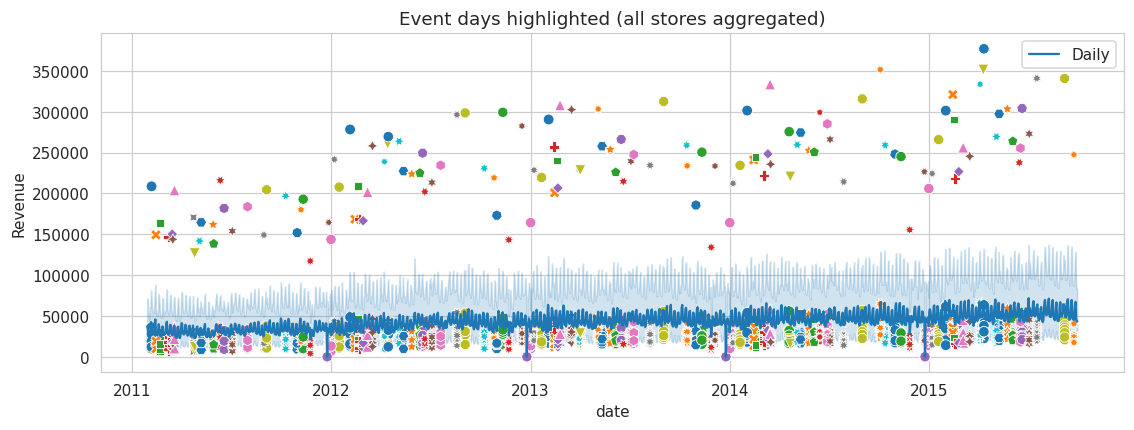

In [16]:
# -----------------------------------------------------------
# Overlay known events on the daily series
# -----------------------------------------------------------
# Merge event labels onto train_df
events = calendar_df.rename(columns={"event": "event_name"})
tmp = train_df.merge(events, on="date", how="left")

plt.figure(figsize=(12,4))
sns.lineplot(data=tmp, x="date", y="revenue", label="Daily")
sns.scatterplot(
    data=tmp[tmp.event_name.notna()],
    x="date", y="revenue",
    hue="event_name", style="event_name",
    palette="tab10", legend=False, s=50
)
plt.title("Event days highlighted (all stores aggregated)")
plt.ylabel("Revenue")
plt.show()

### Uplift bar chart – How much does each event lift sales overall?

**take aways:**
- Only a handful of holidays generate > 5 k lift in the aggregate series.
→ worth creating explicit binary features (is_superbowl, is_easter_week, …).
- Religious holidays (Easter variants, Eid, Ramadan) and U.S. social events (Super Bowl, Father’s Day) dominate; Independence Day is not top-15—interesting anomaly to double-check.
- Since values are absolute dollar, the effect on individual stores will be smaller; we need a per-store view.

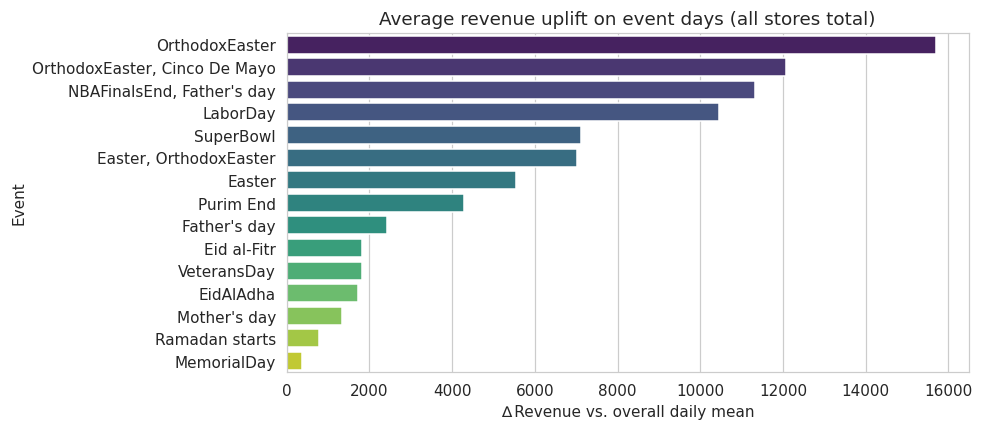

In [17]:
# -----------------------------------------------------------
# 1. Compute uplift = event_day_mean - non_event_mean
# -----------------------------------------------------------
df = train_df.merge(calendar_df, on="date", how="left")

overall_mean = df["revenue"].mean()

uplift = (
    df.groupby("event")["revenue"]
      .mean()
      .sub(overall_mean)             # absolute difference
      .sort_values(ascending=False)
      .head(15)                      # top 15 events
)

# -----------------------------------------------------------
# 2. Plot
# -----------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(y=uplift.index, x=uplift.values, palette="viridis")
plt.title("Average revenue uplift on event days (all stores total)")
plt.xlabel("∆ Revenue vs. overall daily mean")
plt.ylabel("Event")
plt.show()

### “Per-store heat-map” – Which stores benefit from which events?

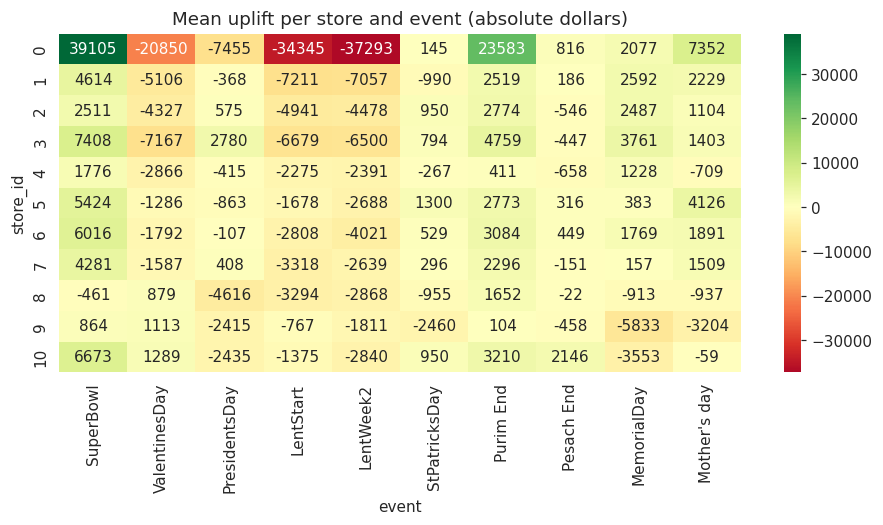

In [18]:
# -----------------------------------------------------------
# 1. Build a pivot table: store_id × event_name
# -----------------------------------------------------------
pivot = (
    df.groupby(["store_id", "event"])["revenue"]
      .mean()
      .unstack("event")                          # columns = events
      .sub(df.groupby("store_id")["revenue"].mean(), axis=0)  # centre per-store
)

# -----------------------------------------------------------
#2. Keep most frequent events to avoid giant table
# -----------------------------------------------------------
top_events = (
    calendar_df["event"]
      .value_counts()
      .head(10)                # pick 10 busiest holidays
      .index
)
pivot = pivot[top_events]

# -----------------------------------------------------------
# 3. Plot heat-map
# -----------------------------------------------------------
plt.figure(figsize=(10,4))
sns.heatmap(pivot, cmap="RdYlGn", center=0, annot=True, fmt=".0f")
plt.title("Mean uplift per store and event (absolute dollars)")
plt.ylabel("store_id")
plt.show()

### Simple outlier screen (per-store whiskers)

**Take-aways**


Scale heterogeneity: store 0 median ≈ 250 k, others 20–60 k → models need either per-store scaling or loss weighting.

Outliers: whiskers extend to zero for all stores—same outage issue; high-end outliers <2 % of points → decide whether to leave or cap.

Skew: slight positive skew for most stores, so a log1p transform could help tree-based models.


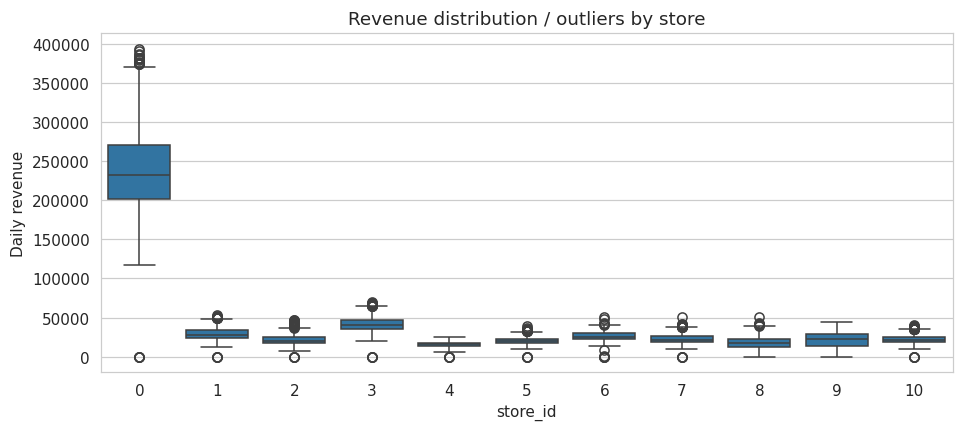

In [19]:
# -----------------------------------------------------------
# Revenue box-plot per store for outlier detection
# -----------------------------------------------------------
plt.figure(figsize=(10,4))
sns.boxplot(data=train_df, x="store_id", y="revenue")
plt.title("Revenue distribution / outliers by store")
plt.ylabel("Daily revenue")
plt.show()

#### ACF/PACF on log-transformed revenues

**Key Takeaways**:

- Weekly seasonality is dominant:

Regular spikes every 7 lags in the ACF (and corresponding seasonal spike in the PACF) confirm a strong 7-day cycle.
→ Include lag 7/14/21 features and set seasonal_period=7 in SARIMA/ETS.

- Short-range memory is modest:

PACF shows one large spike at lag 1, then drops sharply.
→ An AR(1) (plus seasonal AR(1)) is probably enough; ML models just need lag_1.

- Series are still non-stationary in level:

ACF decays slowly rather than cutting off, indicating trend.
→ Use first-differencing or let STL/Prophet remove the trend; keep a time index for tree/NN models.

- Pattern is consistent across hierarchy:

Store 0 (aggregate) and Store 3 (typical branch) look almost identical.
→ One global model with a store_id categorical can share the same seasonal features; no need for custom seasonality per store.

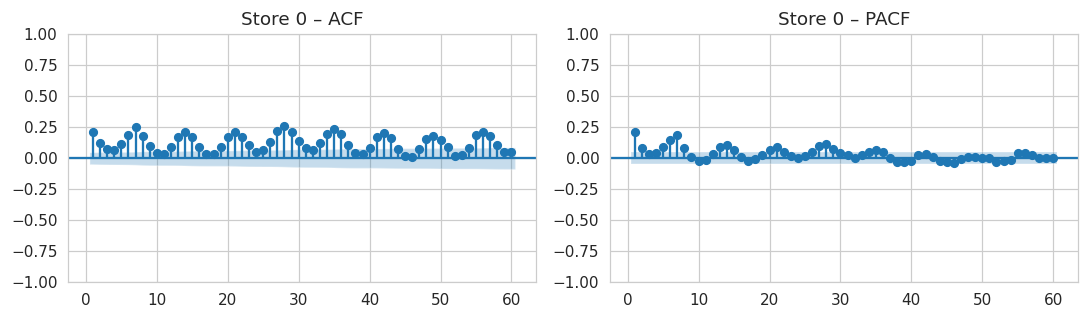

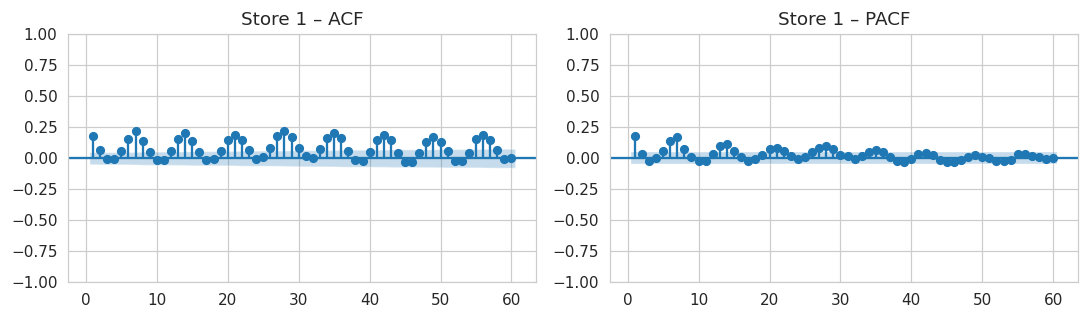

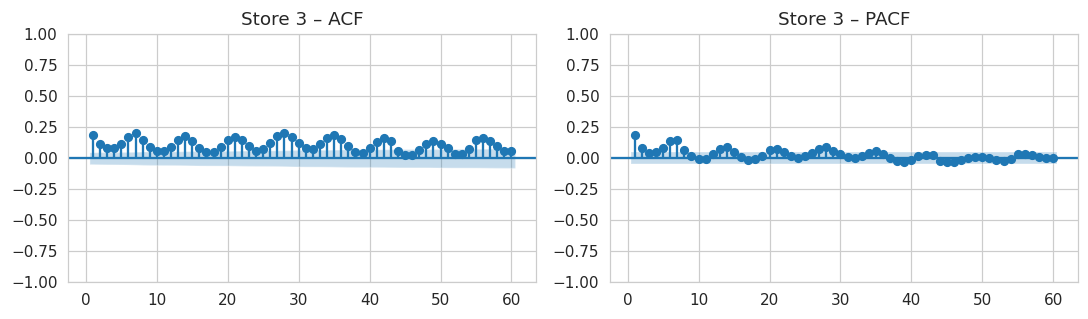

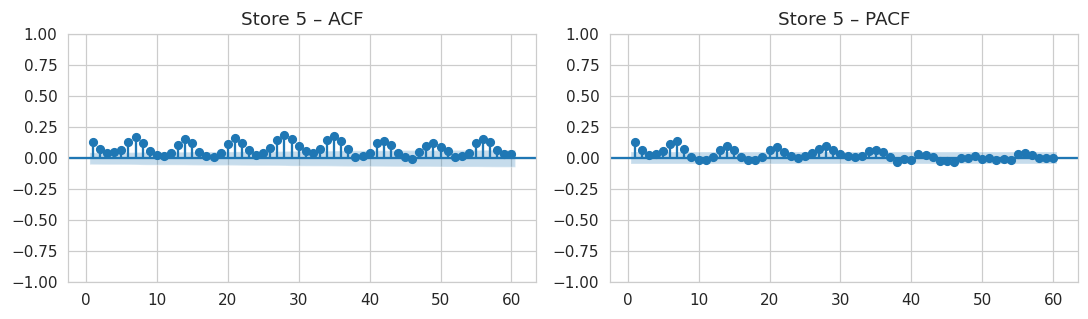

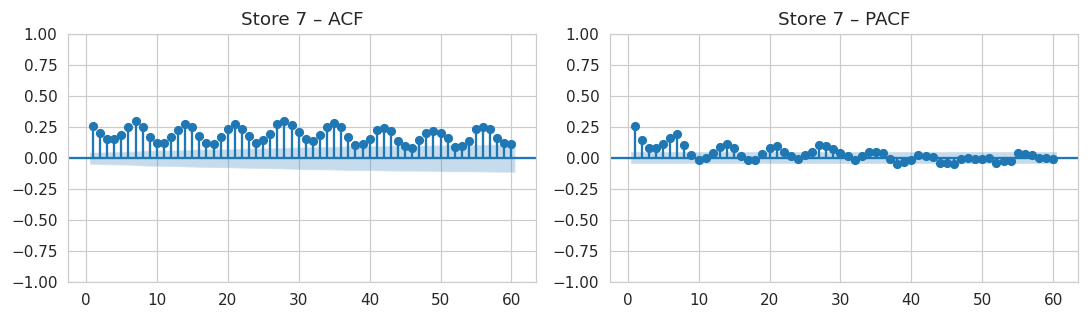

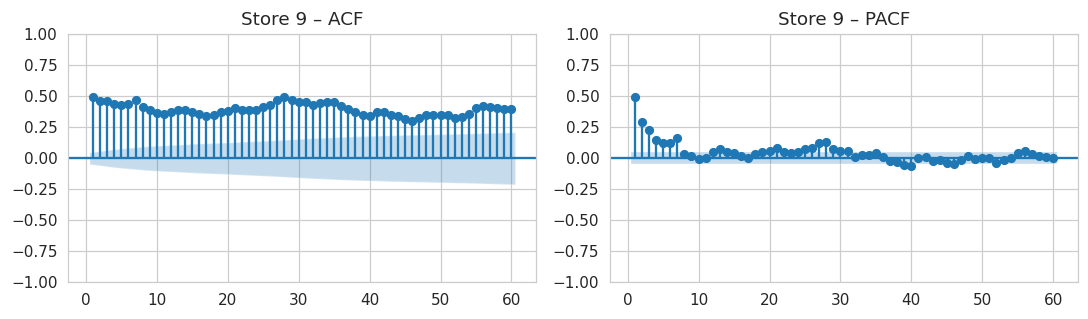

In [20]:
def acf_pacf_plots(store_id, lags=60):
    """Show ACF & PACF on log1p(revenue) for the selected store."""
    series = (
        full_df.query("store_id == @store_id")
               .sort_values("date")             # ensure true time order
               .set_index("date")["revenue"]    # keep zeros; only real NaNs are dropped
               .dropna()
               .pipe(np.log1p)
    )

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    plot_acf(series,  lags=lags, zero=False, ax=ax[0])
    plot_pacf(series, lags=lags, zero=False, ax=ax[1])
    ax[0].set_title(f"Store {store_id} – ACF")
    ax[1].set_title(f"Store {store_id} – PACF")
    plt.tight_layout()
    plt.show()

# run on aggregate + several representative stores
for sid in [0, 1, 3, 5, 7, 9]:
    acf_pacf_plots(sid)

#### Seasonal–sub-series plots

- The bar charts validate the interpretations we drew from ACF/PACF:
    - dominant weekly cycle.
    - mild but present annual drift.
    - pattern shared across stores.

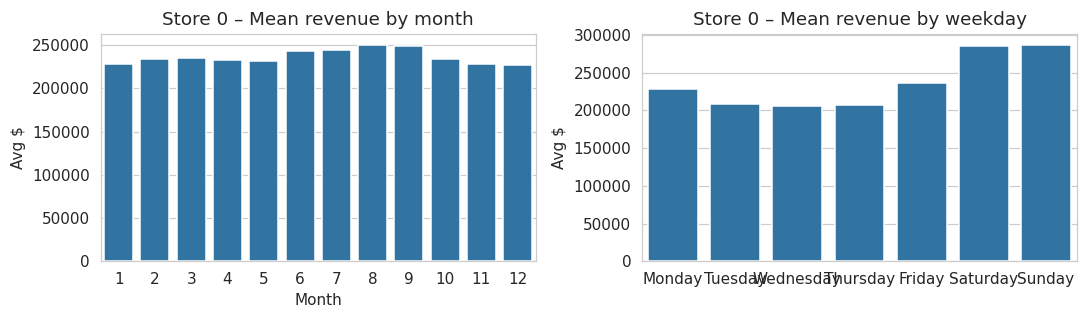

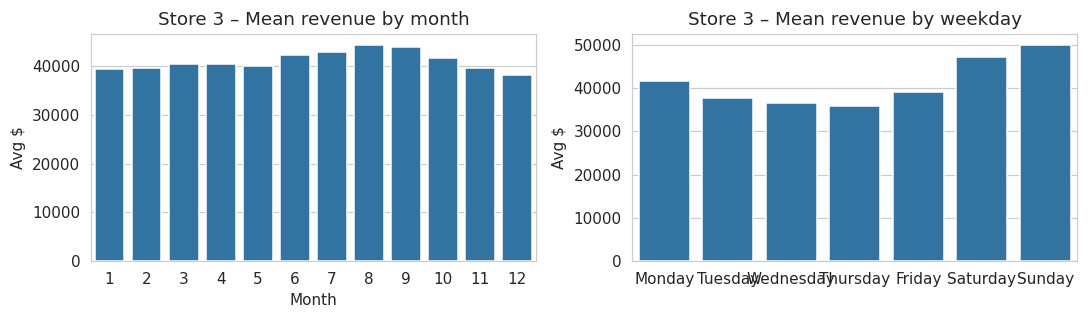

In [21]:
# choose a representative individual store (e.g. 3) and the aggregate (0)
TARGET_STORES = [0, 3]

for sid in TARGET_STORES:
    s = full_df.query("store_id == @sid")

    # ----- Month–of–year profile -------------------------------------------
    moy = (
        s.assign(month=s.date.dt.month)
         .groupby("month").revenue.mean()
    )

    # ----- Day-of-week profile --------------------------------------------
    dow = (
        s.assign(dow=s.date.dt.day_name())
         .groupby("dow").revenue.mean()
         .reindex(["Monday","Tuesday","Wednesday",
                   "Thursday","Friday","Saturday","Sunday"])
    )

    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    sns.barplot(x=moy.index, y=moy.values, ax=ax[0])
    ax[0].set_title(f"Store {sid} – Mean revenue by month")
    ax[0].set_xlabel("Month");  ax[0].set_ylabel("Avg $")

    sns.barplot(x=dow.index, y=dow.values, ax=ax[1])
    ax[1].set_title(f"Store {sid} – Mean revenue by weekday")
    ax[1].set_xlabel("");       ax[1].set_ylabel("Avg $")
    plt.tight_layout(); plt.show()

#### Log 1 + p(revenue) histogram
we are doing it to:
1. Stabilises variance
2. Tame right-skew & outliers
3. Handle multiplicative effects naturally
4. Reduce heteroscedasticity in residuals
5. It is safe with zeros via log1p
6. Easy to invert for submission

- **Variance now tamed**:

After the log1p transform the bulk of points (stores 1-10) forms a neat bell-shaped bump ≈ 10 on the x-axis → modelling on log scale should give more stable gradients and a metric (RMSE) that isn’t dominated by extreme spikes.

- **Tiny spike at 0 = rare closure/outage days:**

Those exact-zero rows are < 0.3 % of the data; keep them as zeros and pass a binary is_zero_day flag. No special zero-inflated model needed.

- **Right-hand hump ≈ 12–13 comes from store 0 (aggregate) + holiday peaks:**

Confirms large scale gap between the all-stores series (~ 220 k dollars per day) and individual stores (~ 22 k dollars).

- **Modelling implication:**

- use store_id as a categorical feature (or train a separate model for store 0) so the learner can treat scales differently; otherwise the global loss may over-focus on store 0.

- **No intermittent-demand issue:**

Because virtually all days have positive sales, we don’t need Croston-type methods or zero-inflated objectives—standard Tweedie/Poisson or plain RMSE is fine.

- **Decision locked-in:**
-
log1p(revenue) will be our target for ML / DL models, with an inverse transform (expm1) right before submission.

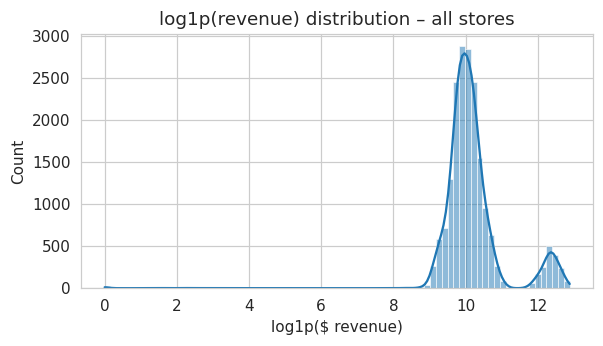

In [22]:
# ------------------------------------------------------------------
# Inspect log1p distribution to decide on variance stabilisation on all stores
# ------------------------------------------------------------------
plt.figure(figsize=(6,3))
sns.histplot(np.log1p(full_df.revenue), bins=80, kde=True)
plt.title("log1p(revenue) distribution – all stores")
plt.xlabel("log1p($ revenue)")
plt.show()

#### Per-store variance & skew table  (log1p + raw for comparison)

In [23]:
# ------------------------------------------------------------------
# Per-store variance & skew table  (log1p + raw for comparison)
# ------------------------------------------------------------------
var_skew_tbl = (
    full_df.assign(log_rev=lambda d: np.log1p(d.revenue))
           .groupby("store_id")
           .agg(raw_mean = ('revenue', 'mean'),
                raw_var  = ('revenue', 'var'),
                raw_skew = ('revenue', sc_stats.skew),
                log_mean = ('log_rev',  'mean'),
                log_var  = ('log_rev',  'var'),
                log_skew = ('log_rev',  sc_stats.skew))
           .round(2)
)
display(var_skew_tbl)

,raw_mean,raw_var,raw_skew,log_mean,log_var,log_skew
store_id,,,,,,
0,237057.45,2.984826e+09,0.15,12.33,0.20,-13.19
1,28756.90,5.954453e+07,0.39,10.21,0.32,-14.11
2,21393.61,3.408220e+07,0.97,9.92,0.18,-10.87
3,41134.34,8.537632e+07,0.08,10.58,0.23,-14.82
4,15469.16,1.186658e+07,-0.15,9.60,0.27,-14.94
5,20081.25,2.243485e+07,0.34,9.86,0.26,-14.81
6,26304.04,3.260776e+07,0.18,10.14,0.22,-15.08
7,22268.39,3.354563e+07,0.47,9.96,0.20,-11.48
8,18289.56,4.998661e+07,0.55,9.72,0.39,-8.83


#### STL decomposition (weekly seasonality)

- Trend panel – smooth upward slope across all stores ⇒ long-run growth; sudden dips match the rare outage/closure days.

- Seasonal (period = 7) – clean, sine-like weekly wave (peaks on Sat/Sun, trough mid-week); amplitude is stable over the 5 years.
→ captures the strong 7-day cycle already seen in ACF/PACF.

- Remainder / Residual – mostly white-noise cloud; big positive spike the day after an outage (catch-up sales).
Stationarity tests (ADF ≪ 0.05 & KPSS ≈ 0.10) confirm these residuals are stationary, so no extra differencing is needed for ARIMA-type baselines.

**Implications:**
1. Weekly dummies or lag-7 features are essential; yearly effects are mild and can be handled with simple month/Fourier terms.
2. Models should include a time-index or growth component for the monotonic trend.
3. Outage days can stay as zeros, but flagging them (is_zero_day) helps ML models learn the rebound that follows.

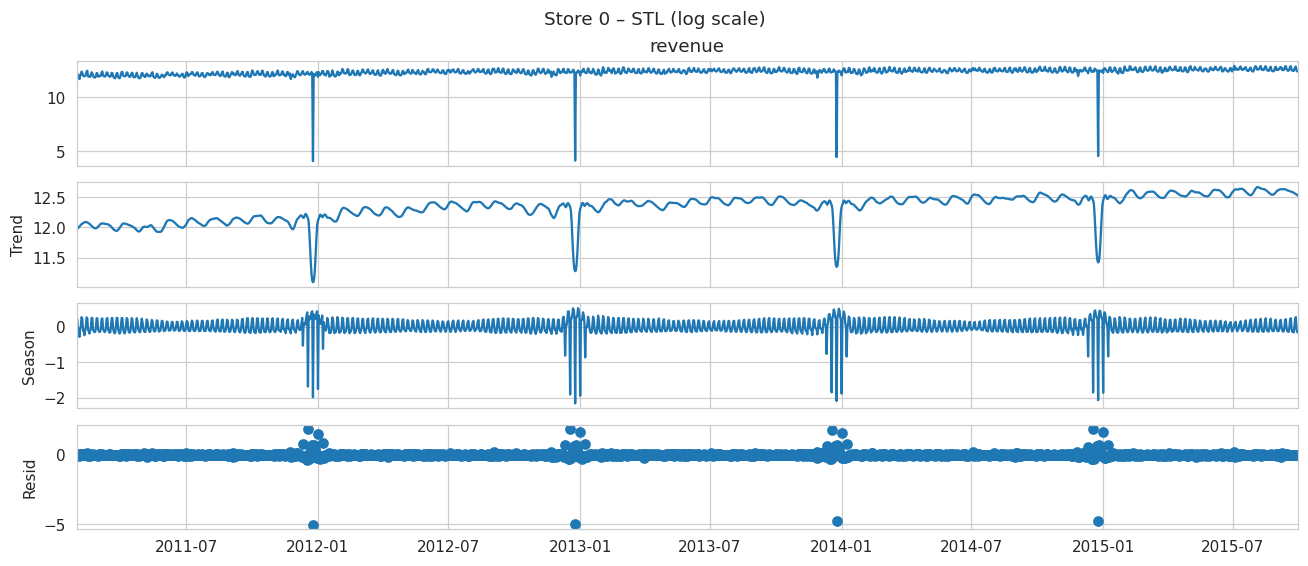

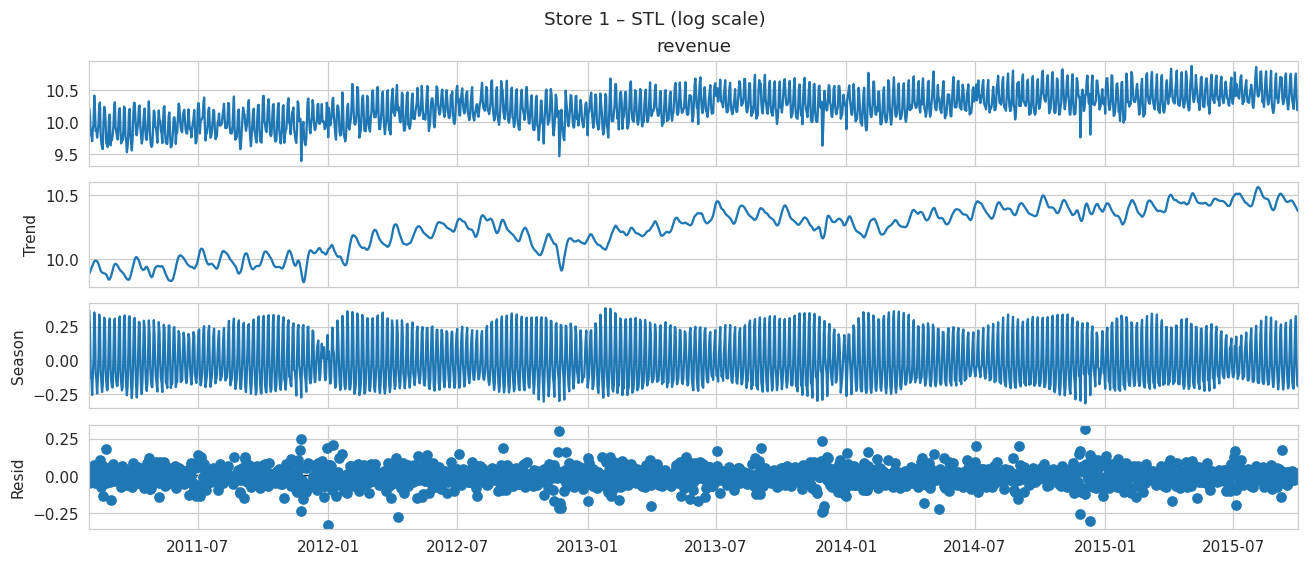

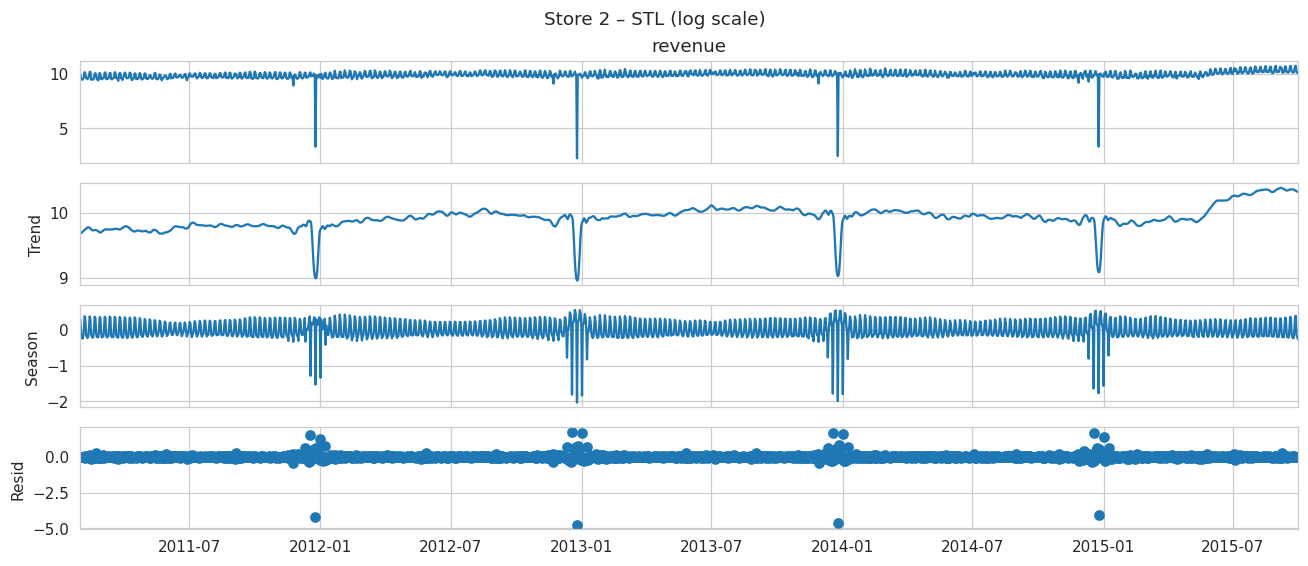

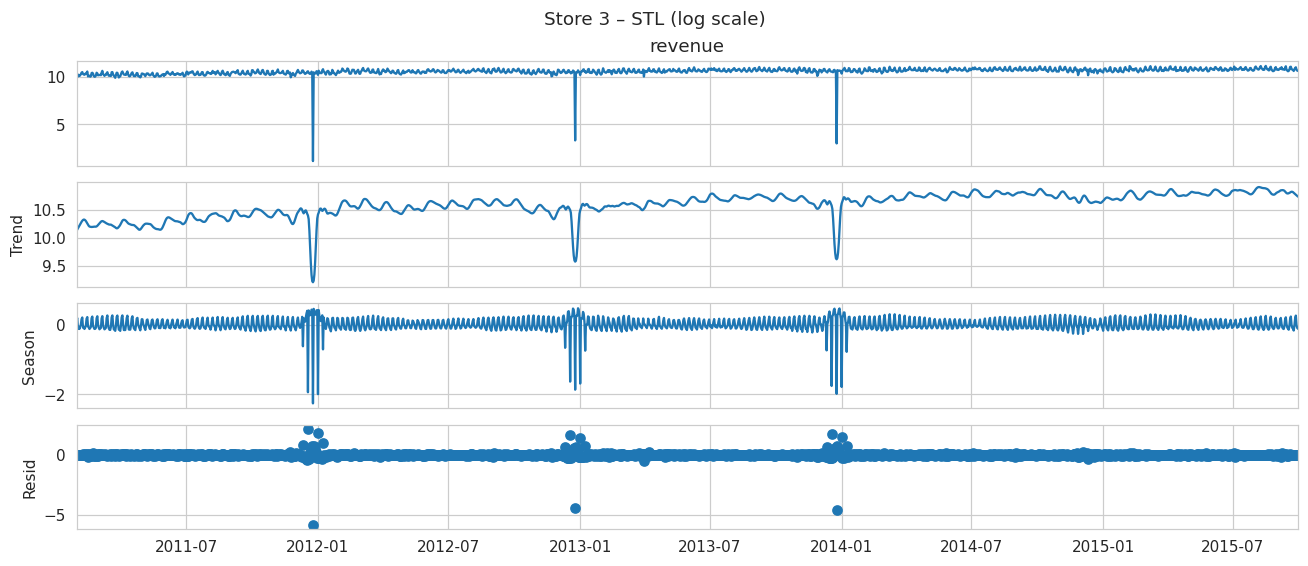

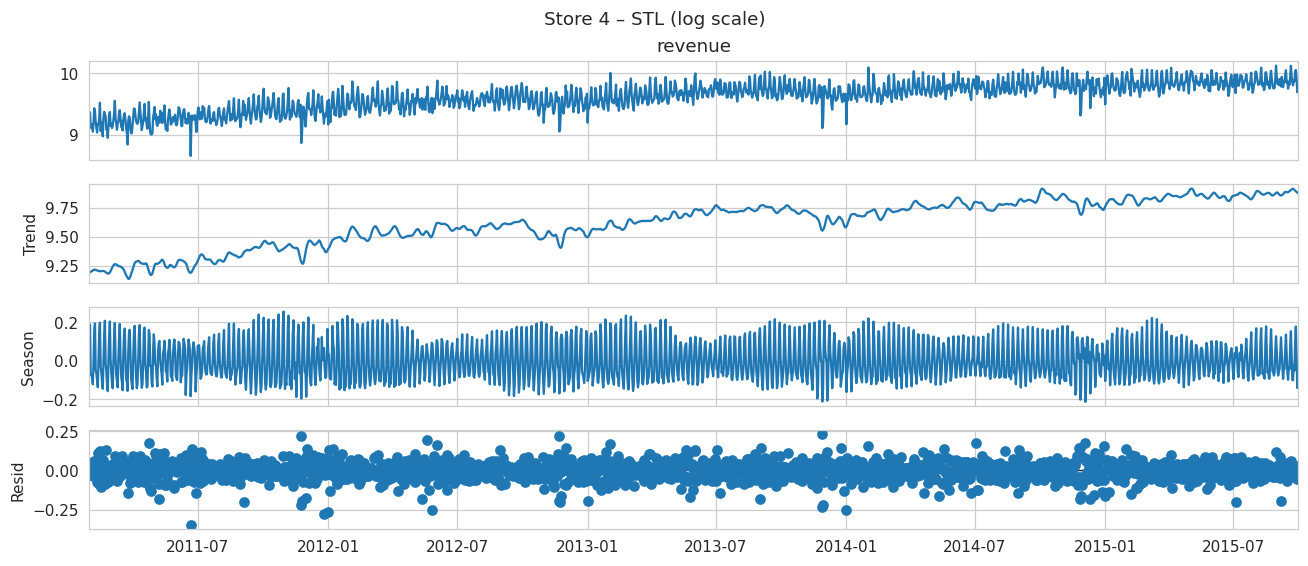

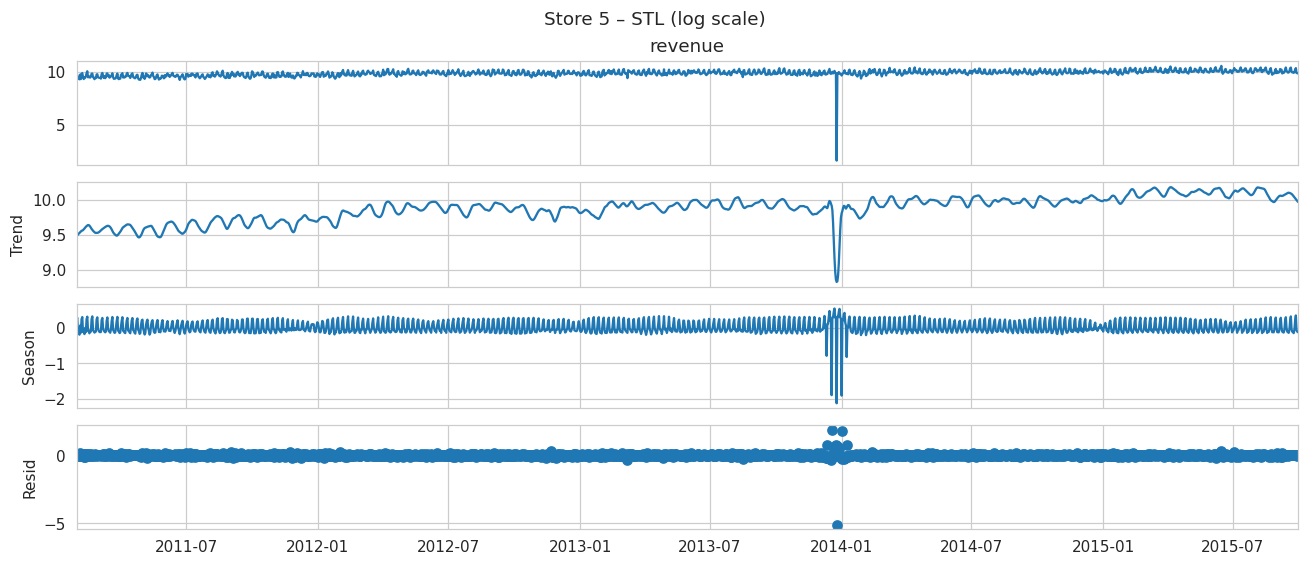

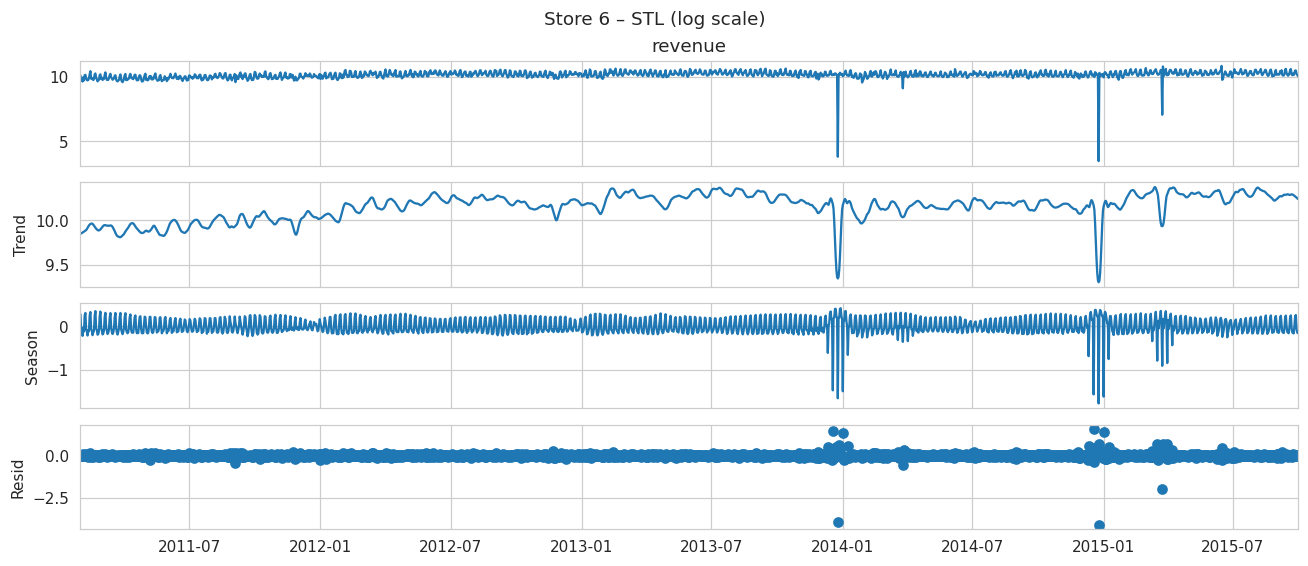

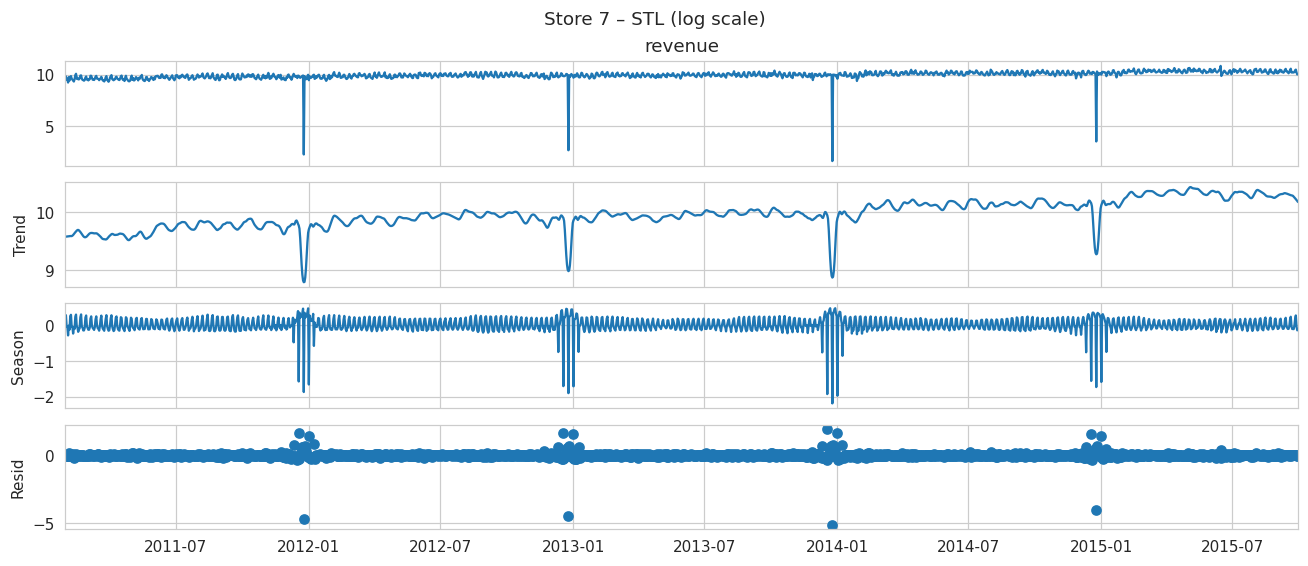

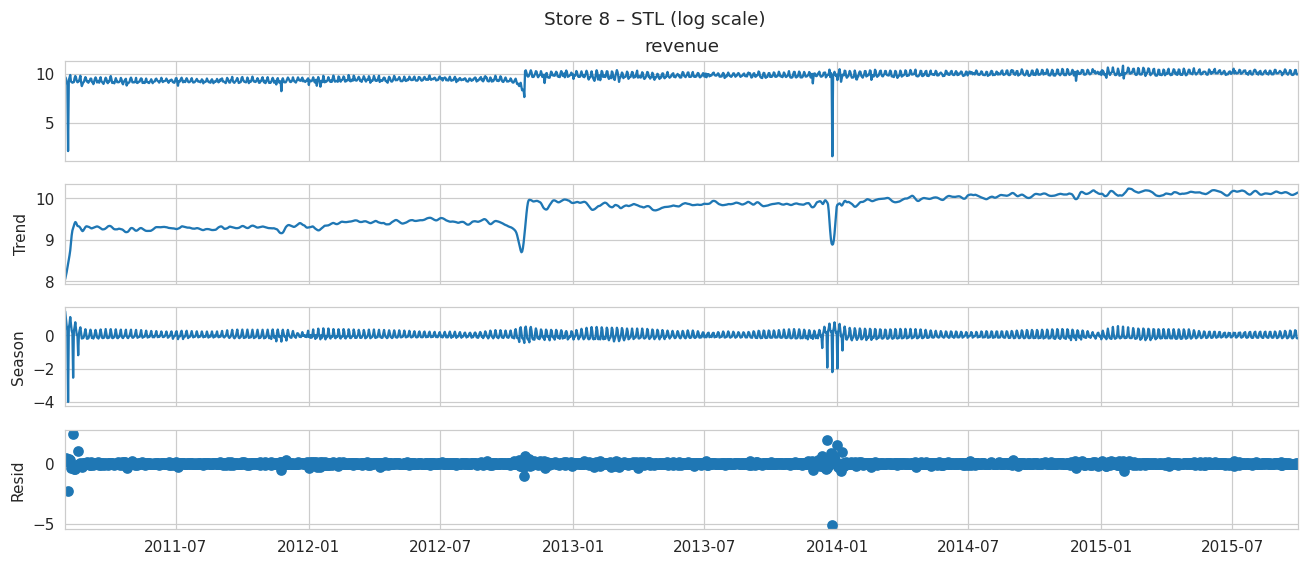

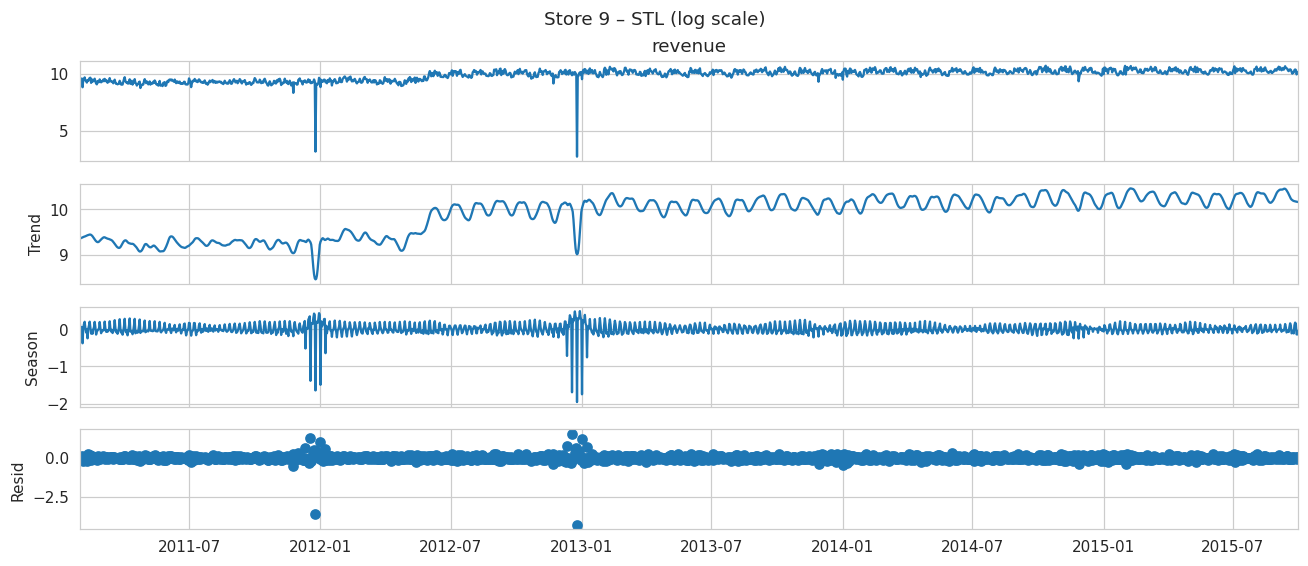

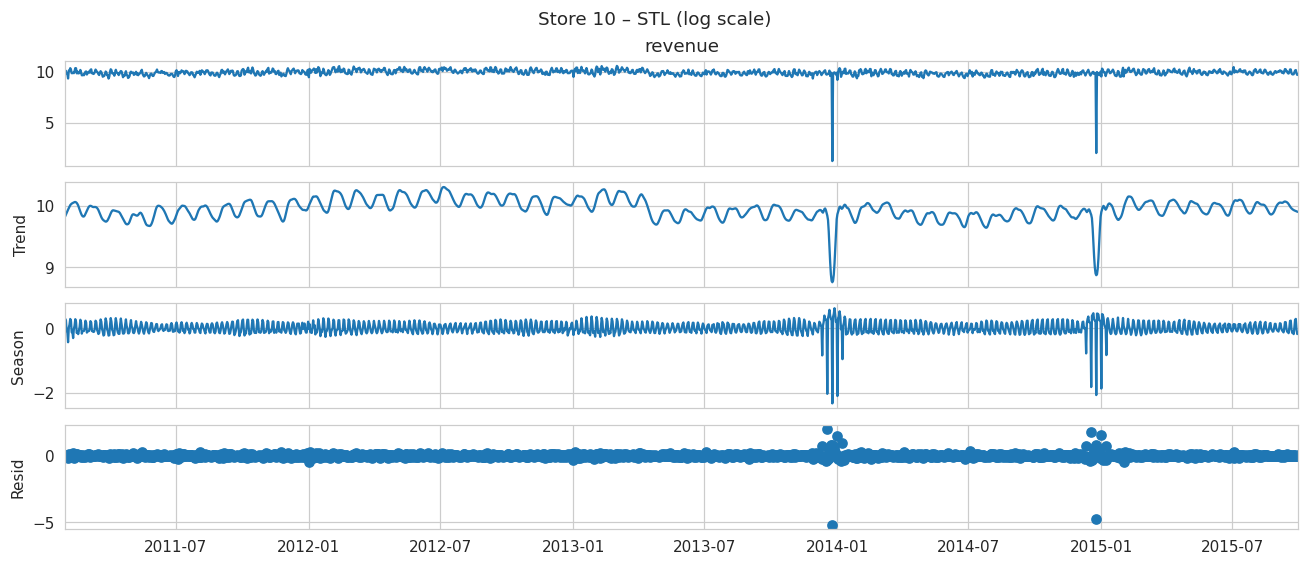

In [24]:
# ------------------------------------------------------------------
# STL decomposition (weekly seasonality)
# ------------------------------------------------------------------
def stl_decomp_plot(store_id, seasonal_len=7):
    series = (
        full_df.query("store_id == @store_id and revenue > 0")
               .set_index("date").revenue
               .pipe(np.log1p)
    )
    stl = STL(series, period=seasonal_len).fit()
    stl.plot()
    plt.suptitle(f"Store {store_id} – STL (log scale)", y=1.02)
    plt.show()
    return stl

# Run for all store IDs in one line
stl_models = {sid: stl_decomp_plot(sid) for sid in sorted(full_df.store_id.unique())}

#### Stationarity tests on STL residuals

- ADF-p < 0.05  → rejects unit-root (non-stationary) ⇒ *stationary*.
- KPSS-p > 0.05 → fails to reject that "Series is stationary around a constant mean" ⇒ cannot prove *non-stationary* ⇒ *stationary*.

**Conclusion:**

After removing trend + weekly seasonality with STL, the residuals of every store are stationary.

No additional differencing or detrending is required before fitting ARMA/SARIMA on those residuals, and machine-learning models can treat the deseasonalised, log-scaled series as stable noise.

In [25]:
# ------------------------------------------------------------------
# Stationarity tests on STL residuals
# ------------------------------------------------------------------

print("ADF & KPSS p-values for STL residuals  (expect ADF<0.05 & KPSS>0.05)")
for sid, stl_obj in stl_models.items():                 # stl_models came from the STL loop
    resid   = stl_obj.resid.dropna()
    adf_p   = adfuller(resid, autolag="AIC")[1]
    kpss_p  = kpss(resid, regression="c", nlags="auto")[1]
    print(f"store {sid:2d}  ADF p={adf_p:.2e}   KPSS p={kpss_p:.3f}")

ADF & KPSS p-values for STL residuals  (expect ADF<0.05 & KPSS>0.05)
store  0  ADF p=8.39e-30   KPSS p=0.100
store  1  ADF p=7.81e-29   KPSS p=0.100
store  2  ADF p=3.09e-30   KPSS p=0.100
store  3  ADF p=9.24e-30   KPSS p=0.100
store  4  ADF p=3.35e-29   KPSS p=0.100
store  5  ADF p=1.49e-29   KPSS p=0.100
store  6  ADF p=4.58e-30   KPSS p=0.100
store  7  ADF p=7.90e-30   KPSS p=0.100
store  8  ADF p=1.59e-28   KPSS p=0.100
store  9  ADF p=5.41e-30   KPSS p=0.100
store 10  ADF p=5.64e-30   KPSS p=0.100


#### Lag-28 PACF check
**Goal:** see whether a 28-day (4-week) memory spike exists. In retail datasets this often shows up because many promotions, payroll cycles, and inventory orders repeat every four weeks.

**Conclusion:**
1. No compelling evidence to require lag_28 as a core feature.
    - For ML models it’s cheap to include and may add a sliver of signal—feel free to add it with low priority.
    - For statistical baselines (SARIMA/ETS) stick with the weekly seasonality only.

<Figure size 880x330 with 0 Axes>

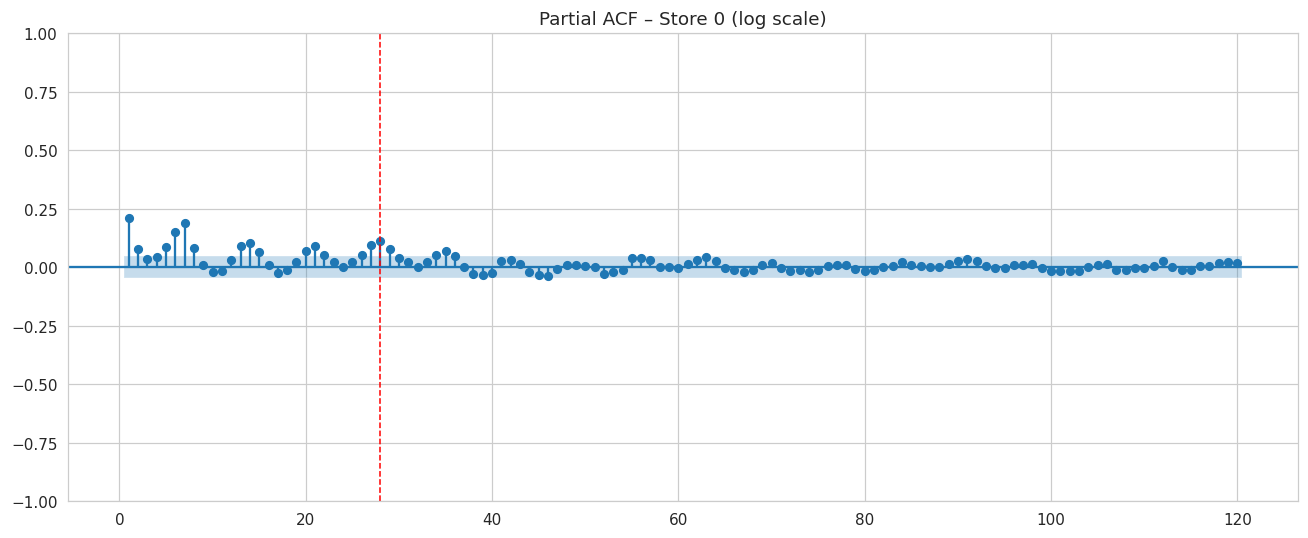

In [26]:
# use the aggregate series so the spike is visible even if it’s faint in one store
series_0 = (
    full_df.query("store_id == 0")
           .set_index("date").revenue
           .pipe(np.log1p)
)

plt.figure(figsize=(8,3))
plot_pacf(series_0, lags=120, zero=False, alpha=0.05)  # show first 120 lags
plt.axvline(28, color="red", ls="--", lw=1)            # highlight lag-28
plt.title("Partial ACF – Store 0 (log scale)")
plt.tight_layout()
plt.show()

In [27]:
full_df.head(10)

,store_id,store_name,date,revenue,event,dow,month,is_zero_day,event_lead1,event_lag1,event_lead2,event_lag2,event_lead3,event_lag3
0,0,All Stores,2011-01-29,204126.52,NaN,5,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,All Stores,2011-01-30,197426.42,NaN,6,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,All Stores,2011-01-31,144267.27,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,All Stores,2011-02-01,151903.00,NaN,1,2,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,All Stores,2011-02-02,117399.88,NaN,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN
5,0,All Stores,2011-02-03,173443.45,NaN,3,2,0,NaN,NaN,NaN,NaN,NaN,NaN
6,0,All Stores,2011-02-04,171972.65,NaN,4,2,0,NaN,NaN,NaN,NaN,NaN,NaN
7,0,All Stores,2011-02-05,233619.38,NaN,5,2,0,NaN,NaN,NaN,NaN,NaN,NaN
8,0,All Stores,2011-02-06,208743.90,SuperBowl,6,2,0,ValentinesDay,None,PresidentsDay,None,LentStart,None
9,0,All Stores,2011-02-07,162911.75,NaN,0,2,0,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# to see the Index of column names
print(full_df.columns)

Index(['store_id', 'store_name', 'date', 'revenue', 'event', 'dow', 'month',
       'is_zero_day', 'event_lead1', 'event_lag1', 'event_lead2', 'event_lag2',
       'event_lead3', 'event_lag3'],
      dtype='object')


In [29]:
# 1. Identify which columns are “features” vs. identifier/target columns
non_features = ['store_id','store_name','date','revenue']
feature_cols = [c for c in full_df.columns if c not in non_features]

print("Feature columns:", feature_cols)
# Feature columns: ['dow','month','is_zero_day',
#                   'event','event_lead1','event_lag1', … ]

# 2. Extract X and y
X = full_df[feature_cols]
y = full_df['revenue']

# 3. Quick sanity‐check
print(X.shape, y.shape)
print(X.head())
print(y.head())


Feature columns: ['event', 'dow', 'month', 'is_zero_day', 'event_lead1', 'event_lag1', 'event_lead2', 'event_lag2', 'event_lead3', 'event_lag3']
(18766, 10) (18766,)
  event  dow  month  is_zero_day event_lead1 event_lag1 event_lead2  \
0   NaN    5      1            0         NaN        NaN         NaN   
1   NaN    6      1            0         NaN        NaN         NaN   
2   NaN    0      1            0         NaN        NaN         NaN   
3   NaN    1      2            0         NaN        NaN         NaN   
4   NaN    2      2            0         NaN        NaN         NaN   

  event_lag2 event_lead3 event_lag3  
0        NaN         NaN        NaN  
1        NaN         NaN        NaN  
2        NaN         NaN        NaN  
3        NaN         NaN        NaN  
4        NaN         NaN        NaN  
0    204126.52
1    197426.42
2    144267.27
3    151903.00
4    117399.88
Name: revenue, dtype: float64


In [30]:
full_df[feature_cols].isnull().sum()


event          17259
dow                0
month              0
is_zero_day        0
event_lead1    17259
event_lag1     17270
event_lead2    17259
event_lag2     17281
event_lead3    17259
event_lag3     17292
dtype: int64

In [31]:
full_df[ full_df['event'].notna() ]

,store_id,store_name,date,revenue,event,dow,month,is_zero_day,event_lead1,event_lag1,event_lead2,event_lag2,event_lead3,event_lag3
8,0,All Stores,2011-02-06,208743.90,SuperBowl,6,2,0,ValentinesDay,None,PresidentsDay,None,LentStart,None
16,0,All Stores,2011-02-14,149322.23,ValentinesDay,0,2,0,PresidentsDay,SuperBowl,LentStart,None,LentWeek2,None
23,0,All Stores,2011-02-21,163868.92,PresidentsDay,0,2,0,LentStart,ValentinesDay,LentWeek2,SuperBowl,StPatricksDay,None
39,0,All Stores,2011-03-09,146929.55,LentStart,2,3,0,LentWeek2,PresidentsDay,StPatricksDay,ValentinesDay,Purim End,SuperBowl
46,0,All Stores,2011-03-16,150190.83,LentWeek2,2,3,0,StPatricksDay,LentStart,Purim End,PresidentsDay,"OrthodoxEaster, Easter",ValentinesDay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18664,10,Wisconsin – Badger Crossing,2015-06-21,21180.60,Father's day,6,6,0,IndependenceDay,Ramadan starts,Eid al-Fitr,NBAFinalsEnd,LaborDay,NBAFinalsStart
18677,10,Wisconsin – Badger Crossing,2015-07-04,20598.22,IndependenceDay,5,7,0,Eid al-Fitr,Father's day,LaborDay,Ramadan starts,EidAlAdha,NBAFinalsEnd
18691,10,Wisconsin – Badger Crossing,2015-07-18,23972.92,Eid al-Fitr,5,7,0,LaborDay,IndependenceDay,EidAlAdha,Father's day,ColumbusDay,Ramadan starts
18742,10,Wisconsin – Badger Crossing,2015-09-07,24211.38,LaborDay,0,9,0,EidAlAdha,Eid al-Fitr,ColumbusDay,IndependenceDay,Halloween,Father's day


In [32]:
# Example: simple label‐encode ‘event’; leave dummies for numeric dow/month
le = LabelEncoder()
full_df['event_le'] = le.fit_transform(full_df['event'].fillna('NoEvent'))

# drop or keep original as you prefer
# full_df.drop('event', axis=1, inplace=True)
feature_cols = [c for c in feature_cols if c!='event'] + ['event_le']

# instead of above, use 1 hot vectore if desirecd

# full_df = pd.get_dummies(full_df, columns=['event'], dummy_na=False)


In [33]:
lag_cols = [f"event_lead{i}" for i in range(1,4)] + [f"event_lag{i}" for i in range(1,4)]

for col in lag_cols:
    # fill NaNs with a “NoEvent” sentinel (so they get their own code)
    full_df[col] = full_df[col].fillna("NoEvent")
    le_events_lead_lag = LabelEncoder()
    full_df[col+"_le"] = le_events_lead_lag.fit_transform(full_df[col])

# drop the old string columns
full_df.drop(columns=lag_cols, inplace=True)

# update your feature list
feature_cols = [c for c in feature_cols if c not in lag_cols] + [col+"_le" for col in lag_cols]


In [34]:
full_df.head()

,store_id,store_name,date,revenue,event,dow,month,is_zero_day,event_le,event_lead1_le,event_lead2_le,event_lead3_le,event_lag1_le,event_lag2_le,event_lag3_le
0,0,All Stores,2011-01-29,204126.52,NaN,5,1,0,21,21,21,21,21,21,21
1,0,All Stores,2011-01-30,197426.42,NaN,6,1,0,21,21,21,21,21,21,21
2,0,All Stores,2011-01-31,144267.27,NaN,0,1,0,21,21,21,21,21,21,21
3,0,All Stores,2011-02-01,151903.00,NaN,1,2,0,21,21,21,21,21,21,21
4,0,All Stores,2011-02-02,117399.88,NaN,2,2,0,21,21,21,21,21,21,21


## Train - Test split

In [35]:
# # 3. Time‐based train/validation split
# # ensure ‘date’ is datetime
# full_df['date'] = pd.to_datetime(full_df['date'])
#
# # choose a split date, e.g. last 28 days for validation
# split_date = full_df['date'].max() - pd.Timedelta(days=28)
#
# train_df = full_df[full_df['date'] < split_date].copy()
# val_df   = full_df[full_df['date'] >= split_date].copy()
#
# X_train, y_train = train_df[feature_cols], train_df['revenue']
# X_val,   y_val   = val_df[feature_cols],   val_df['revenue']
#
# print("Train:", X_train.shape, "Validation:", X_val.shape)


In [36]:
# 1. Ensure date is datetime
full_df['date'] = pd.to_datetime(full_df['date'])

# 2. Define window sizes
val_days  = 28   # e.g. use last 28 days for validation
test_days = 28   # e.g. use final 28 days for test

# 3. Compute cut-off dates
max_date    = full_df['date'].max()
test_start  = max_date - pd.Timedelta(days=test_days - 1)
val_start   = test_start - pd.Timedelta(days=val_days)

# 4. Split
train_df = full_df[ full_df['date'] <     val_start ]
val_df   = full_df[(full_df['date'] >=    val_start) &
                   (full_df['date'] <    test_start)]
test_df  = full_df[ full_df['date'] >=    test_start ]

# 5. Extract X/y
non_features = ['store_id','store_name','date','revenue','event']
feature_cols = [c for c in full_df.columns if c not in non_features]

X_train, y_train = train_df[feature_cols], train_df['revenue']
X_val,   y_val   = val_df[feature_cols],   val_df['revenue']
X_test,  y_test  = test_df[feature_cols],  test_df['revenue']

# 6. Sanity check shapes & date ranges
print("Train:", train_df['date'].min(), "→", train_df['date'].max(), X_train.shape)
print("Val:  ", val_df['date'].min(),   "→", val_df['date'].max(),   X_val.shape)
print("Test: ", test_df['date'].min(),  "→", test_df['date'].max(),  X_test.shape)

Train: 2011-01-29 00:00:00 → 2015-08-05 00:00:00 (18150, 10)
Val:   2015-08-06 00:00:00 → 2015-09-02 00:00:00 (308, 10)
Test:  2015-09-03 00:00:00 → 2015-09-30 00:00:00 (308, 10)


In [37]:
## 4. Fit a LightGBM baseline

train_data = lgb.Dataset(X_train, label=y_train)
val_data   = lgb.Dataset(X_val,   label=y_val, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

bst = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

# quick validation RMSE
y_pred = bst.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
test_rmse = root_mean_squared_error(y_test, bst.predict(X_test))
print(f"Validation RMSE: {rmse:.4f}")
print(f'Test RMSE: {test_rmse:.4f}')



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 18150, number of used features: 10
[LightGBM] [Info] Start training from score 42723.078822
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 63192.1	valid_1's rmse: 79233.8
[100]	training's rmse: 63180.3	valid_1's rmse: 79206.1
Early stopping, best iteration is:
[74]	training's rmse: 63181.1	valid_1's rmse: 79186.1
Validation RMSE: 79186.1202
Test RMSE: 79489.1775


In [38]:
# # 2) Define the Optuna objective
# def objective(trial):
#     # Suggest hyper-parameters
#     param = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 16, 128),
#         'max_depth': trial.suggest_int('max_depth', 3, 12),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
#         'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
#         'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
#         'seed': 42
#     }

#     # Create datasets
#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data   = lgb.Dataset(X_val,   label=y_val, reference=train_data)

#     # Train with early stopping
#     gbm = lgb.train(
#         param,
#         train_data,
#         num_boost_round=1000,
#         valid_sets=[val_data],
#         callbacks=[
#             lgb.early_stopping(stopping_rounds=50),
#             lgb.log_evaluation(period=0)  # silent
#         ]
#     )

#     # Predict & evaluate on validation set
#     preds = gbm.predict(X_val)
#     return root_mean_squared_error(y_val, preds)

# # 3) Run the study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# print("Best params:", study.best_params)
# print(f"Best validation RMSE: {study.best_value:.4f}")

# # 4) (Optional) Train final model on train+val, test on hold-out
# best_params = study.best_params.copy()
# best_params.update({'objective':'regression','metric':'rmse','verbosity':-1})

# # Combine train+val
# train_val_df = pd.concat([train_df, val_df])
# train_val_data = lgb.Dataset(train_val_df[feature_cols], label=train_val_df['revenue'])

# final_gbm = lgb.train(
#     best_params,
#     train_val_data,
#     num_boost_round=study.best_trial.number  # or fixed rounds
# )

# y_test_pred = final_gbm.predict(X_test)
# print(f"Test RMSE: {root_mean_squared_error(y_test, y_test_pred):.4f}")


### Traning and using backbone of TFT

In [39]:
# assume full_df sorted by ['store_id','date']
window_sizes = [7, 28, 90]
for w in window_sizes:
    full_df[f"rev_roll_mean_{w}"] = (
        full_df
        .groupby("store_id")["revenue"]
        .transform(lambda x: x.shift(1).rolling(window=w).mean())
    )
    full_df[f"rev_roll_std_{w}"] = (
        full_df
        .groupby("store_id")["revenue"]
        .transform(lambda x: x.shift(1).rolling(window=w).std())
    )
# exponential moving average
full_df["rev_ewm_28"] = (
    full_df
    .groupby("store_id")["revenue"]
    .transform(lambda x: x.shift(1).ewm(span=28).mean())
)


# 1) List your new rolling feature columns
rolling_cols = [
    "rev_roll_mean_7",   "rev_roll_std_7",
    "rev_roll_mean_28",  "rev_roll_std_28",
    "rev_roll_mean_90",  "rev_roll_std_90",
    "rev_ewm_28"
]

# 2) Create missing-value indicator flags
for col in rolling_cols:
    full_df[col + "_nan"] = full_df[col].isna().astype(int)

# 3) Fill the NaNs (here we choose 0, but you can pick any constant or series-level stat)
full_df[rolling_cols] = full_df[rolling_cols].fillna(0)
 

In [62]:
# Hyper‐parameters
max_prediction_length = 28
max_encoder_length   = 45

# 1) PREPARE df_tft
df_tft = full_df.copy()
df_tft["date"]     = pd.to_datetime(df_tft["date"])
df_tft["time_idx"] = (df_tft["date"] - df_tft["date"].min()).dt.days

# Keep original `event` if you like, but make sure to train on `event_le`
# and cast all categoricals to string
for col in ["store_id","dow","month","event_le"]:
    df_tft[col] = df_tft[col].astype(str)
df_tft["group_id"] = df_tft["store_id"]  # now a string

# 2) TRAIN / VAL split on the raw DataFrame
cutoff   = df_tft["time_idx"].max() - max_prediction_length
df_train = df_tft[ df_tft["time_idx"] <= cutoff ]
# for validation we need the last encoder window + the prediction window
df_val   = df_tft[ df_tft["time_idx"] > cutoff - max_encoder_length ]

# 3) COMMON TimeSeriesDataSet arguments (extended)
common_kwargs = dict(
    time_idx="time_idx",
    target="revenue",
    group_ids=["group_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,

    static_categoricals=["store_id"],
    static_reals=[],

    time_varying_known_categoricals=["dow","month","event_le"],

    # include all the numeric flags + the new rolling features
    time_varying_known_reals=[
        "time_idx",
        "is_zero_day",
        "event_lead1_le","event_lag1_le",
        "event_lead2_le","event_lag2_le",
        "event_lead3_le","event_lag3_le",
        # rolling windows (filled)
        "rev_roll_mean_7",  "rev_roll_std_7",
        "rev_roll_mean_28", "rev_roll_std_28",
        "rev_roll_mean_90", "rev_roll_std_90",
        "rev_ewm_28",
        # missing‐value indicators
        "rev_roll_mean_7_nan",  "rev_roll_std_7_nan",
        "rev_roll_mean_28_nan", "rev_roll_std_28_nan",
        "rev_roll_mean_90_nan", "rev_roll_std_90_nan",
        "rev_ewm_28_nan",
    ],

    time_varying_unknown_reals=["revenue"],

    target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)


# 1) compute, per store, the start‐index of the *last* window
windows_per_store = 50
total_window_length = max_encoder_length + max_prediction_length - 1
val_starts = {}
for store in df_tft["group_id"].unique():
    last_idx = df_tft.loc[df_tft.group_id == store, "time_idx"].max()
    # the window that ends at last_idx starts at:
    last_window_start = last_idx - total_window_length
    # so 50 windows back start at:
    first_val_start = last_window_start - (windows_per_store - 1)
    val_starts[store] = first_val_start

# 2) build raw train / val DataFrames
#    - train needs all rows *before* the first validation window's encoder
#    - val   needs all rows *from* the first_val_start up through the end
train_slices = []
val_slices   = []
for store, start in val_starts.items():
    grp = df_tft[df_tft.group_id == store]
    # train: up to (start + encoder_length - 1) so that the last train window can form
    train_cutoff = start + max_encoder_length - 1
    train_slices.append(grp[grp.time_idx <= train_cutoff])
    # val: from `start` on
    val_slices.append(grp[grp.time_idx >= start])

train_df = pd.concat(train_slices, ignore_index=True)
val_df   = pd.concat(val_slices,   ignore_index=True)

# 3) Instantiate datasets
common_kwargs.update(dict(  # reuse your existing common_kwargs
    # nothing changes here...
))

train_dataset = TimeSeriesDataSet(train_df, **common_kwargs)

# from_dataset will reuse encodings, categorical mappings, normalizers, etc.
val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    data=val_df,
    predict_mode=False,       # so we get all sliding windows, not just 1 per series
    randomize_length=False    # no random cropping
)

print(f"Train windows: {len(train_dataset)}")
print(f" Val windows: {len(val_dataset)}  (should be ≈ {windows_per_store * df_tft.group_id.nunique()})")

print("Train windows:", len(train_dataset), "Validation windows:", len(val_dataset))
# Should print something like: 17400  & 550  (if you have 11 stores × 50 windows = 550)


# 6) INSTANTIATE the TFT backbone
#    — note: **use** train_dataset here (was ts_dataset before)
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=4e-3,
    hidden_size=33,
    attention_head_size=3,
    dropout=0.255,
    hidden_continuous_size=54,
    output_size=1,    # predict a single value (revenue)
    loss=RMSE(),
    log_interval=10,
    reduce_on_plateau_patience=4
)

# 8) TRAIN with PyTorch Lightning 2.x API
# 1) Callback to record losses
class LossHistory(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses: list[float] = []
        self.val_losses:   list[float] = []

    def on_train_epoch_end(self, trainer: Trainer, pl_module) -> None:
        metrics = trainer.callback_metrics
        # 'train_loss' is the default name Lightning uses for your training_step loss
        if "train_loss" in metrics:
            self.train_losses.append(metrics["train_loss"].item())

    def on_validation_epoch_end(self, trainer: Trainer, pl_module) -> None:
        metrics = trainer.callback_metrics
        # skip if still in sanity check (no val_loss yet)
        if "val_loss" in metrics:
            self.val_losses.append(metrics["val_loss"].item())


# 1) Freeze everything
for param in tft.parameters():
    param.requires_grad = False

# 2) Unfreeze just the three modules
modules_to_train = ["pos_wise_ff", "pre_output_gate_norm", "output_layer"]
for module_name in modules_to_train:
    module = getattr(tft, module_name)
    for param in module.parameters():
        param.requires_grad = True

# 3) Sanity‐check
print("Trainable parameters:")
for name, param in tft.named_parameters():
    if param.requires_grad:
        print("  ✓", name)

loss_history = LossHistory()
early_stop   = EarlyStopping(monitor="val_loss", patience=3)

trainer = Trainer(
    max_epochs=7,
    accelerator="auto",
    devices=1,
    gradient_clip_val=0.1,
    callbacks=[loss_history, early_stop]
)



trainer.fit(
    tft,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 593    | train
3  | prescalers                         | ModuleDict                      | 2.9 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 17.2 K | train
5  | encoder_variable_selection         

Train windows: 17127
 Val windows: 550  (should be ≈ 550)
Train windows: 17127 Validation windows: 550
Trainable parameters:
  ✓ pos_wise_ff.fc1.weight
  ✓ pos_wise_ff.fc1.bias
  ✓ pos_wise_ff.fc2.weight
  ✓ pos_wise_ff.fc2.bias
  ✓ pos_wise_ff.gate_norm.glu.fc.weight
  ✓ pos_wise_ff.gate_norm.glu.fc.bias
  ✓ pos_wise_ff.gate_norm.add_norm.norm.weight
  ✓ pos_wise_ff.gate_norm.add_norm.norm.bias
  ✓ pre_output_gate_norm.glu.fc.weight
  ✓ pre_output_gate_norm.glu.fc.bias
  ✓ pre_output_gate_norm.add_norm.norm.weight
  ✓ pre_output_gate_norm.add_norm.norm.bias
  ✓ output_layer.weight
  ✓ output_layer.bias


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=7` reached.


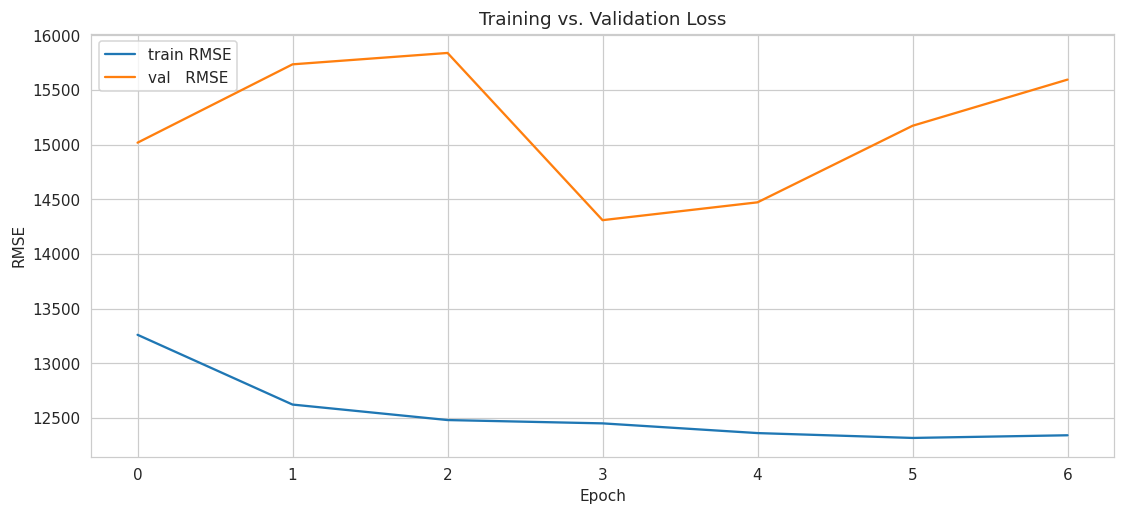

In [63]:
plt.plot(loss_history.train_losses, label="train RMSE")
plt.plot(loss_history.val_losses,   label="val   RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

In [59]:
# 1) Define the Optuna objective
def objective(trial):
    # 1a) Sample hyper-parameters
    lr      = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    hidden  = trial.suggest_int("hidden_size", 8, 64)
    heads   = trial.suggest_int("attention_head_size", 1, 8)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    hcont   = trial.suggest_int("hidden_continuous_size", 8, 64)

    # 1b) Build a fresh TFT for each trial
    tft = TemporalFusionTransformer.from_dataset(
        train_dataset,
        learning_rate=lr,
        hidden_size=hidden,
        attention_head_size=heads,
        dropout=dropout,
        hidden_continuous_size=hcont,
        output_size=1,
        loss=RMSE(),
        log_interval=0,                   # turn off per‐batch logging
        reduce_on_plateau_patience=3      # shrink LR if no-improve
    )

    # 1c) (Optionally) freeze/unfreeze layers here exactly as you like
    # e.g. only keep small head trainable:
    for p in tft.parameters(): p.requires_grad = False
    for m in ("pos_wise_ff","pre_output_gate_norm","output_layer"):
        for p in getattr(tft, m).parameters(): p.requires_grad = True

    # 1d) Early stopping + checkpointing
    early_stop = EarlyStopping(
        monitor="val_loss", 
        patience=3, 
        mode="min", 
        verbose=False
    )
    ckpt = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=False,
    )

    # 1e) Trainer for this trial (fewer epochs to save time)
    trainer = Trainer(
        max_epochs=5,
        accelerator="auto",
        devices=1,
        callbacks=[early_stop, ckpt],
        enable_model_summary=False,
        logger=False,
    )
    trainer.fit(
        tft, 
        train_dataloaders=train_dl, 
        val_dataloaders=val_dl
    )

    # 1f) Load best model and evaluate final val loss
    best_tft = TemporalFusionTransformer.load_from_checkpoint(ckpt.best_model_path)
    val_metrics = trainer.validate(
        best_tft,
        dataloaders=val_dl,
        verbose=False
    )
    # val_metrics is a list of dicts; default val_loss key is "val_loss"
    return val_metrics[0]["val_loss"]

# 2) Create & run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# 3) Inspect best results
print("Best validation RMSE:", study.best_value)
print("Best hyper-parameters:")
for k, v in study.best_params.items():
    print(f"  • {k} = {v}")

[I 2025-06-09 16:00:29,874] A new study created in memory with name: no-name-be434e1d-f90e-4c95-ac4b-88a3f0633edd
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:01:34,377] Trial 0 finished with value: 17704.73046875 and parameters: {'learning_rate': 0.009584244110366583, 'hidden_size': 29, 'attention_head_size': 6, 'dropout': 0.1180213417871045, 'hidden_continuous_size': 42}. Best is trial 0 with value: 17704.73046875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:02:54,183] Trial 1 finished with value: 18771.34375 and parameters: {'learning_rate': 0.0007377745216647666, 'hidden_size': 61, 'attention_head_size': 6, 'dropout': 0.26513506469001985, 'hidden_continuous_size': 48}. Best is trial 0 with value: 17704.73046875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:04:01,196] Trial 2 finished with value: 86452.1875 and parameters: {'learning_rate': 0.003785157227748923, 'hidden_size': 59, 'attention_head_size': 1, 'dropout': 0.17100677820683974, 'hidden_continuous_size': 10}. Best is trial 0 with value: 17704.73046875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:05:22,043] Trial 3 finished with value: 19550.138671875 and parameters: {'learning_rate': 0.000271376462224581, 'hidden_size': 11, 'attention_head_size': 2, 'dropout': 0.43497118265226153, 'hidden_continuous_size': 48}. Best is trial 0 with value: 17704.73046875.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:06:44,096] Trial 4 finished with value: 15696.6318359375 and parameters: {'learning_rate': 0.003909956000160241, 'hidden_size': 33, 'attention_head_size': 3, 'dropout': 0.2549405622408155, 'hidden_continuous_size': 54}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:07:51,121] Trial 5 finished with value: 23630.974609375 and parameters: {'learning_rate': 0.005506413211676969, 'hidden_size': 40, 'attention_head_size': 8, 'dropout': 0.011783118180699381, 'hidden_continuous_size': 8}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:09:13,552] Trial 6 finished with value: 21062.060546875 and parameters: {'learning_rate': 0.00010883808063467373, 'hidden_size': 38, 'attention_head_size': 8, 'dropout': 0.20095024637075032, 'hidden_continuous_size': 22}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:10:20,703] Trial 7 finished with value: 23167.138671875 and parameters: {'learning_rate': 0.0031882763209540197, 'hidden_size': 31, 'attention_head_size': 2, 'dropout': 0.39377482876738823, 'hidden_continuous_size': 42}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:11:41,745] Trial 8 finished with value: 19371.4765625 and parameters: {'learning_rate': 0.0005958929350264616, 'hidden_size': 48, 'attention_head_size': 3, 'dropout': 0.3094763779416482, 'hidden_continuous_size': 38}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:13:03,627] Trial 9 finished with value: 17702.21875 and parameters: {'learning_rate': 0.00021680387924485, 'hidden_size': 19, 'attention_head_size': 3, 'dropout': 0.3036485015787939, 'hidden_continuous_size': 31}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:14:24,104] Trial 10 finished with value: 18379.11328125 and parameters: {'learning_rate': 0.0024622005595675697, 'hidden_size': 22, 'attention_head_size': 5, 'dropout': 0.06973487329063277, 'hidden_continuous_size': 64}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:15:42,411] Trial 11 finished with value: 22264.10546875 and parameters: {'learning_rate': 0.0015737322679169657, 'hidden_size': 14, 'attention_head_size': 4, 'dropout': 0.3396477787546448, 'hidden_continuous_size': 26}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:16:59,228] Trial 12 finished with value: 22000.017578125 and parameters: {'learning_rate': 0.00015963003492654415, 'hidden_size': 21, 'attention_head_size': 4, 'dropout': 0.25038546620781166, 'hidden_continuous_size': 61}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:18:21,674] Trial 13 finished with value: 22931.623046875 and parameters: {'learning_rate': 0.00037764358657526464, 'hidden_size': 25, 'attention_head_size': 3, 'dropout': 0.48933217316845934, 'hidden_continuous_size': 29}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:19:22,545] Trial 14 finished with value: 24820.876953125 and parameters: {'learning_rate': 0.0014527292294132406, 'hidden_size': 47, 'attention_head_size': 1, 'dropout': 0.3402886632421701, 'hidden_continuous_size': 54}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:20:43,120] Trial 15 finished with value: 22437.435546875 and parameters: {'learning_rate': 0.0002754704941632775, 'hidden_size': 15, 'attention_head_size': 3, 'dropout': 0.1899152737147919, 'hidden_continuous_size': 21}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:22:00,085] Trial 16 finished with value: 22084.0078125 and parameters: {'learning_rate': 0.0011342005973974736, 'hidden_size': 8, 'attention_head_size': 5, 'dropout': 0.2868681759917777, 'hidden_continuous_size': 33}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:23:19,130] Trial 17 finished with value: 19112.603515625 and parameters: {'learning_rate': 0.009087389869705444, 'hidden_size': 32, 'attention_head_size': 2, 'dropout': 0.38897857013741544, 'hidden_continuous_size': 56}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:24:42,256] Trial 18 finished with value: 22644.263671875 and parameters: {'learning_rate': 0.0005021454330410214, 'hidden_size': 45, 'attention_head_size': 4, 'dropout': 0.1494936452077167, 'hidden_continuous_size': 14}. Best is trial 4 with value: 15696.6318359375.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 16:25:59,206] Trial 19 finished with value: 20962.298828125 and parameters: {'learning_rate': 0.002078246550427237, 'hidden_size': 18, 'attention_head_size': 6, 'dropout': 0.21901745468770023, 'hidden_continuous_size': 34}. Best is trial 4 with value: 15696.6318359375.


Best validation RMSE: 15696.6318359375
Best hyper-parameters:
  • learning_rate = 0.003909956000160241
  • hidden_size = 33
  • attention_head_size = 3
  • dropout = 0.2549405622408155
  • hidden_continuous_size = 54


In [65]:
# 1) Naïve baseline forecasts
baseline_tensor = Baseline().predict(val_dl)    # torch.Tensor on GPU
baseline_np     = baseline_tensor.detach().cpu().numpy()  # now a NumPy array
baseline_flat   = baseline_np.flatten()                   # shape (n_series*pred_len,)

# 2) TFT forecasts
tft_tensor = tft.predict(val_dl)               # torch.Tensor on GPU
tft_np     = tft_tensor.detach().cpu().numpy() # now a NumPy array
tft_flat   = tft_np.flatten()                  # shape (n_series*pred_len,)

# 3) True values for those windows
df_pred = (
    df_tft[df_tft["time_idx"] > cutoff]
    .sort_values(["group_id", "time_idx"])
)
actuals = df_pred["revenue"].values            # NumPy array, shape matches

# 4) Sanity check
print("Shapes:", baseline_flat.shape, tft_flat.shape, actuals.shape)

# 5) Compute RMSE
baseline_rmse = np.sqrt(mean_squared_error(actuals, baseline_flat))
tft_rmse      = np.sqrt(mean_squared_error(actuals, tft_flat))

print(f"Naïve baseline RMSE: {baseline_rmse:.4f}")
print(f"       TFT RMSE: {tft_rmse:.4f}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Shapes: (308,) (308,) (308,)
Naïve baseline RMSE: 17546.7857
       TFT RMSE: 15594.9189


### NBEATS backbone

In [109]:
# 0) drop all extra features—just keep time_idx, group_id, and the target revenue
ds_df = df_tft[["group_id","time_idx","revenue"]].copy()

# 1) define cutoffs
prediction_length = max_prediction_length  # 28
encoder_length   = max_encoder_length      # 45
last_date        = ds_df.time_idx.max()
cutoff           = last_date - prediction_length

# 2) build the dataset for N-BEATS
nbeats_kwargs = dict(
    time_idx="time_idx",
    target="revenue",
    group_ids=["group_id"],
    # encoder / decoder lengths
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    # NO categoricals or extra reals
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=[],
    time_varying_unknown_reals=["revenue"],
    # turn OFF all the extra TFT flags
    add_relative_time_idx=False,
    add_target_scales=False,
    add_encoder_length=False,
)


# 2) train_df up through cutoff
train_df = ds_df[ds_df.time_idx <= cutoff]

# 3) val_df from (cutoff - encoder_length + 1) onward
val_df = ds_df[ds_df.time_idx >= cutoff - (encoder_length - 1)]

# 4) build train_dataset as before
train_dataset = TimeSeriesDataSet(train_df, **nbeats_kwargs)

# 5) build validation dataset *in predict mode*
val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    data=val_df,
    predict=True,           # only one window per series
    stop_randomization=True # no random cropping
)


# 3) dataloaders
train_dl = train_dataset.to_dataloader(train=True,  batch_size=128, num_workers=8)
val_dl   = val_dataset.to_dataloader(  train=False, batch_size=128, num_workers=8)


In [113]:
loss_history = LossHistory()

# 3) Instantiate N-BEATS from the training dataset
nbeats = NBeats.from_dataset(
    train_dataset,
    learning_rate=0.0016856369312234169,
    widths=[128, 128],
    log_interval=10,                # batch‐level logging
    log_val_interval=1,             # epoch‐level validation logging
    weight_decay=0.0007087244106668896,
    backcast_loss_ratio=0.8174123040463586
)

# 4) Early stopping callback
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    mode="min"
)
checkpoint_cb = ModelCheckpoint(
    monitor="val_loss",       # which metric to monitor
    mode="min",               # we want to minimize val_loss
    save_top_k=1,             # only keep the single best epoch
    dirpath="checkpoints/",   # folder to save into
    filename="nbeats-{epoch:02d}-{val_loss:.4f}",
)

# 5) Trainer with both callbacks
trainer = Trainer(
    max_epochs=50,
    accelerator="auto",
    devices=1,
    gradient_clip_val=0.1,
    callbacks=[checkpoint_cb, loss_history, early_stop]
)

# 6) Fit
trainer.fit(
    nbeats,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl
)


# afterwards, the best checkpoint path is:
best_path = checkpoint_cb.best_model_path
print("Best checkpoint saved at:", best_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 245 K  | train
-------------------------------------------------------
245 K     Trainable params
0         Non-trainable params
245 K     Total params
0.982     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best checkpoint saved at: /checkpoints/nbeats-epoch=03-val_loss=0.6021.ckpt


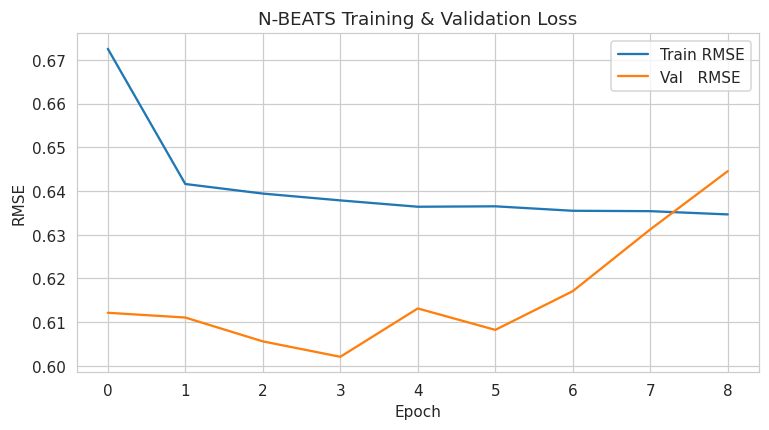

In [114]:
# 7) Plot train vs. val RMSE
plt.figure(figsize=(8,4))
plt.plot(loss_history.train_losses, label="Train RMSE")
plt.plot(loss_history.val_losses,   label="Val   RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("N-BEATS Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [117]:
best_model = NBeats.load_from_checkpoint("checkpoints/nbeats-epoch=03-val_loss=0.6021.ckpt")

# 1) get model forecasts: shape (n_windows, prediction_length)
raw_preds = best_model.predict(val_dl)
# if it’s still a torch.Tensor, move it to CPU / numpy
if isinstance(raw_preds, torch.Tensor):
    raw_preds = raw_preds.detach().cpu().numpy()
# flatten to (n_windows * prediction_length,)
y_pred = raw_preds.reshape(-1)

# 2) gather the true decoder targets
true_list = []
for x, y in val_dl:
    # y is a tuple; the first element is the tensor of shape (batch_size, full_window)
    full_window = y[0]  
    # crop to last `prediction_length` columns
    decoder_target = full_window[:, -prediction_length:]
    arr = decoder_target.detach().cpu().numpy()  # now (batch_size, prediction_length)
    true_list.append(arr.reshape(-1))            # flatten to 1-D
y_true = np.concatenate(true_list, axis=0)

# quick sanity check
print("true vs pred lengths:", y_true.shape, y_pred.shape)


# 4) Compute RMSE
rmse = root_mean_squared_error(y_true, y_pred)
print(f"Validation RMSE: {rmse:.4f}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


true vs pred lengths: (308,) (308,)
Validation RMSE: 7310.0200


In [105]:
def objective(trial):
    # 1) suggest hyperparameters
    lr    = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    wd    = trial.suggest_loguniform("weight_decay",    1e-5, 1e-2)
    width = trial.suggest_categorical("width", [64, 128, 256])
    backcast_loss_ratio = trial.suggest_uniform("backcast_loss_ratio", 0.1, 0.9)

    # 2) instantiate N-BEATS with two stacks (the default)
    model = NBeats.from_dataset(
        train_dataset,
        learning_rate=lr,
        weight_decay=wd,
        # keep using the two default "generic" stacks
        widths=[width, width],
        backcast_loss_ratio=backcast_loss_ratio,
        log_interval=0,
        log_val_interval=0,
    )

    # 3) early stopping on val_loss
    early_stop = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=3,
        mode="min",
    )

    # 4) quick Trainer
    trainer = Trainer(
        max_epochs=10,
        accelerator="auto",
        devices=1,
        callbacks=[early_stop],
        enable_progress_bar=True,
        enable_model_summary=True,
    )

    # 5) fit
    trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

    # 6) return the final val_loss
    return trainer.callback_metrics["val_loss"].item()


# 7) run the study
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner()
)
study.optimize(objective, n_trials=20, timeout=3600)

print("Best hyperparameters:", study.best_trial.params)
print("Best validation RMSE:", study.best_value)

[I 2025-06-09 17:15:06,528] A new study created in memory with name: no-name-f9c6d21b-232d-411f-b1d4-b8a4bf1ba6d1
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 883 K  | train
-------------------------------------------------------
883 K     Trainable params
0         Non-trainable params
883 K     Total params
3.536     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:15:25,248] Trial 0 finished with value: 0.6678923964500427 and parameters: {'learning_rate': 0.005302960939033168, 'weight_decay': 0.006901583683203058, 'width': 256, 'backcast_loss_ratio': 0.7790397050018956}. Best is trial 0 with value: 0.6678923964500427.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 245 K  | train
-------------------------------------------------------
245 K     Trainable params
0         Non-trainable params
245 K     Total params
0.982     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-06-09 17:16:02,935] Trial 1 finished with value: 0.6480178236961365 and parameters: {'learning_rate': 0.00012987880122022026, 'weight_decay': 1.3245683686476684e-05, 'width': 128, 'backcast_loss_ratio': 0.6613207639369165}. Best is trial 1 with value: 0.6480178236961365.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 245 K  | train
-------------------------------------------------------
245 K     Trainable params
0         Non-tr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:16:36,620] Trial 2 finished with value: 0.639206051826477 and parameters: {'learning_rate': 0.0015566861172673055, 'weight_decay': 1.6659440153029117e-05, 'width': 128, 'backcast_loss_ratio': 0.2575661387324487}. Best is trial 2 with value: 0.639206051826477.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 883 K  | train
-------------------------------------------------------
883 K     Trainable params
0         Non-trainable params
883 K     Total params
3.536     Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:16:52,149] Trial 3 finished with value: 0.6216095685958862 and parameters: {'learning_rate': 0.0007756291186391421, 'weight_decay': 0.00015041587053660603, 'width': 256, 'backcast_loss_ratio': 0.6409171165619219}. Best is trial 3 with value: 0.6216095685958862.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 883 K  | train
-------------------------------------------------------
883 K     Trainable params
0         Non-trainable params
883 K     Total params
3.536     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:17:14,999] Trial 4 finished with value: 0.6272138357162476 and parameters: {'learning_rate': 0.0017076588197233705, 'weight_decay': 2.451304024491634e-05, 'width': 256, 'backcast_loss_ratio': 0.5897279121301552}. Best is trial 3 with value: 0.6216095685958862.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 245 K  | train
-------------------------------------------------------
245 K     Trainable params
0         Non-trainable params
245 K     Total params
0.982     To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:17:34,315] Trial 5 finished with value: 0.6258082985877991 and parameters: {'learning_rate': 0.007393950686261025, 'weight_decay': 0.00629737854454646, 'width': 128, 'backcast_loss_ratio': 0.5624458282762442}. Best is trial 3 with value: 0.6216095685958862.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 245 K  | train
-------------------------------------------------------
245 K     Trainable params
0         Non-trainable params
245 K     Total params
0.982     Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:17:49,650] Trial 6 finished with value: 0.6445035934448242 and parameters: {'learning_rate': 0.0015395213588269882, 'weight_decay': 1.8673573344456935e-05, 'width': 128, 'backcast_loss_ratio': 0.5725378230690207}. Best is trial 3 with value: 0.6216095685958862.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 883 K  | train
-------------------------------------------------------
883 K     Trainable params
0         Non-trainable params
883 K     Total params
3.536     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:18:12,444] Trial 7 finished with value: 0.610031247138977 and parameters: {'learning_rate': 0.0016856369312234169, 'weight_decay': 0.0007087244106668896, 'width': 256, 'backcast_loss_ratio': 0.8174123040463586}. Best is trial 7 with value: 0.610031247138977.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 245 K  | train
-------------------------------------------------------
245 K     Trainable params
0         Non-trainable params
245 K     Total params
0.982     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-06-09 17:18:49,654] Trial 8 finished with value: 0.6103566884994507 and parameters: {'learning_rate': 0.0012261357125967736, 'weight_decay': 0.0010353951867525413, 'width': 128, 'backcast_loss_ratio': 0.4024496286969521}. Best is trial 7 with value: 0.610031247138977.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 73.5 K | train
-------------------------------------------------------
73.5 K    Trainable params
0         Non-train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-06-09 17:19:27,124] Trial 9 finished with value: 0.6252171993255615 and parameters: {'learning_rate': 0.00013196541825882718, 'weight_decay': 2.0054004019424443e-05, 'width': 64, 'backcast_loss_ratio': 0.10690343327928115}. Best is trial 7 with value: 0.610031247138977.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 73.5 K | train
-------------------------------------------------------
73.5 K    Trainable params
0         Non-tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:19:57,124] Trial 10 finished with value: 0.622218668460846 and parameters: {'learning_rate': 0.00041018188931962583, 'weight_decay': 0.0005710468370742014, 'width': 64, 'backcast_loss_ratio': 0.39733562357155816}. Best is trial 7 with value: 0.610031247138977.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 883 K  | train
-------------------------------------------------------
883 K     Trainable params
0         Non-trainable params
883 K     Total params
3.536     To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:20:23,142] Trial 11 finished with value: 0.6262953281402588 and parameters: {'learning_rate': 0.0027273503714696883, 'weight_decay': 0.0013038671163017983, 'width': 256, 'backcast_loss_ratio': 0.880391707159377}. Best is trial 7 with value: 0.610031247138977.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 245 K  | train
-------------------------------------------------------
245 K     Trainable params
0         Non-trainable params
245 K     Total params
0.982     Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:20:42,448] Trial 12 finished with value: 0.6294298768043518 and parameters: {'learning_rate': 0.0005359166057898741, 'weight_decay': 0.0015474029924284248, 'width': 128, 'backcast_loss_ratio': 0.3782282322168594}. Best is trial 7 with value: 0.610031247138977.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 883 K  | train
-------------------------------------------------------
883 K     Trainable params
0         Non-trainable params
883 K     Total params
3.536     To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:21:02,156] Trial 13 finished with value: 0.6132157444953918 and parameters: {'learning_rate': 0.0034069804480154333, 'weight_decay': 0.00019873261497544562, 'width': 256, 'backcast_loss_ratio': 0.40141831811790146}. Best is trial 7 with value: 0.610031247138977.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 73.5 K | train
-------------------------------------------------------
73.5 K    Trainable params
0         Non-trainable params
73.5 K    Total params
0.294     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:21:24,173] Trial 14 finished with value: 0.6105536222457886 and parameters: {'learning_rate': 0.0007927981098596606, 'weight_decay': 0.0006048286766404245, 'width': 64, 'backcast_loss_ratio': 0.7584392599025949}. Best is trial 7 with value: 0.610031247138977.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 245 K  | train
-------------------------------------------------------
245 K     Trainable params
0         Non-trainable params
245 K     Total params
0.982     Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:21:39,801] Trial 15 finished with value: 0.6355366110801697 and parameters: {'learning_rate': 0.0002708113999271285, 'weight_decay': 9.310524237590556e-05, 'width': 128, 'backcast_loss_ratio': 0.26528928624397574}. Best is trial 7 with value: 0.610031247138977.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 883 K  | train
-------------------------------------------------------
883 K     Trainable params
0         Non-trainable params
883 K     Total params
3.536     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:21:55,300] Trial 16 finished with value: 0.6363776922225952 and parameters: {'learning_rate': 0.002767155138625026, 'weight_decay': 0.0015653037038802916, 'width': 256, 'backcast_loss_ratio': 0.4802805006044835}. Best is trial 7 with value: 0.610031247138977.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 883 K  | train
-------------------------------------------------------
883 K     Trainable params
0         Non-trainable params
883 K     Total params
3.536     Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:22:25,593] Trial 17 finished with value: 0.6123180389404297 and parameters: {'learning_rate': 0.009635199374565846, 'weight_decay': 0.0030497024060991453, 'width': 256, 'backcast_loss_ratio': 0.8894970640582287}. Best is trial 7 with value: 0.610031247138977.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 245 K  | train
-------------------------------------------------------
245 K     Trainable params
0         Non-trainable params
245 K     Total params
0.982     Tot

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-09 17:22:49,605] Trial 18 finished with value: 0.6156089305877686 and parameters: {'learning_rate': 0.0011139989339354222, 'weight_decay': 6.634609163704481e-05, 'width': 128, 'backcast_loss_ratio': 0.23846242637715404}. Best is trial 7 with value: 0.610031247138977.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 73.5 K | train
-------------------------------------------------------
73.5 K    Trainable params
0         Non-trainable params
73.5 K    Total params
0.294     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-06-09 17:23:25,343] Trial 19 finished with value: 0.6184799075126648 and parameters: {'learning_rate': 0.00038454969588102173, 'weight_decay': 0.00041073690861274064, 'width': 64, 'backcast_loss_ratio': 0.7193305476195597}. Best is trial 7 with value: 0.610031247138977.


Best hyperparameters: {'learning_rate': 0.0016856369312234169, 'weight_decay': 0.0007087244106668896, 'width': 256, 'backcast_loss_ratio': 0.8174123040463586}
Best validation RMSE: 0.610031247138977


In [136]:
# 1) define your window lengths
encoder_length   = max_encoder_length   # e.g. 45
prediction_length = max_prediction_length  # e.g. 28

# 2) take *only* the last encoder_length rows for each group
hist_cutoff = df_tft["time_idx"].max() - (encoder_length - 1)
# this keeps the final encoder_length days
historical_last = (
    df_tft
    .loc[df_tft.time_idx >= hist_cutoff, ["group_id","time_idx","revenue"]]
    .copy()
)

# 3) parse your submission IDs into group_id + time_idx as before
submission = pd.read_csv("data/forecast_submission.csv")
submission[["group_id","date_str"]] = submission["id"].str.split("_", expand=True)
submission["date"]     = pd.to_datetime(submission["date_str"], format="%Y%m%d")
date_min = df_tft["date"].min()
submission["time_idx"] = (submission["date"] - date_min).dt.days
submission["group_id"] = submission["group_id"].astype(str)
# placeholder revenue (NaN) is fine in predict mode
submission["revenue"] = np.nan
submission = submission[["group_id","time_idx","revenue"]]

# 4) concat the two to create exactly one window per group
future_df = pd.concat([historical_last, submission], ignore_index=True)

# 5) build the prediction‐mode dataset
pred_ds = TimeSeriesDataSet.from_dataset(
    train_dataset,      # your original training TimeSeriesDataSet
    data=future_df,     # only last history + NaN‐future
    stop_randomization=True,
    predict_mode=True   # <— THIS ensures NaNs in “revenue” are allowed
)

# 3) Turn into a DataLoader
pred_dl = pred_ds.to_dataloader(train=False, batch_size=128, num_workers=4)

# 4) Run your trained model
raw_preds = best_model.predict(pred_dl)         # shape = (n_series, prediction_length)
if hasattr(raw_preds, "detach"):
    raw_preds = raw_preds.detach().cpu().numpy()
flat_preds = raw_preds.reshape(-1)

# 5) Fill back into your CSV
sub = pd.read_csv("data/forecast_submission.csv")
sub["prediction"] = flat_preds

ValueError: 1012 (67.15%) of revenue values were found to be NA or infinite (even after encoding). NA values are not allowed `allow_missing_timesteps` refers to missing rows, not to missing values. Possible strategies to fix the issue are (a) dropping the variable revenue, (b) using `NaNLabelEncoder(add_nan=True)` for categorical variables, (c) filling missing values and/or (d) optionally adding a variable indicating filled values

In [ ]:
# 3) Save the filled submission
submission.to_csv("data/forecast_submission_filled.csv", index=False)

# 4) Show the first few rows
submission.head()

In [129]:
historical_last

,group_id,time_idx,revenue
1661,0,1661,295766.10
1662,0,1662,268058.53
1663,0,1663,254217.45
1664,0,1664,246515.98
1665,0,1665,278225.38
...,...,...,...
18761,10,1701,25689.55
18762,10,1702,26557.53
18763,10,1703,19067.53
18764,10,1704,16467.95


In [134]:
future_df.head(60)

,group_id,time_idx,revenue
0,0,1661,295766.10
1,0,1662,268058.53
2,0,1663,254217.45
3,0,1664,246515.98
4,0,1665,278225.38
5,0,1666,341693.90
6,0,1667,365835.60
7,0,1668,267040.97
8,0,1669,242181.85
9,0,1670,241926.33


In [128]:
submission

,group_id,time_idx,revenue
0,0,1706,NaN
1,0,1707,NaN
2,0,1708,NaN
3,0,1709,NaN
4,0,1710,NaN
...,...,...,...
1007,10,1793,NaN
1008,10,1794,NaN
1009,10,1795,NaN
1010,10,1796,NaN


In [127]:
ds_df

,group_id,time_idx,revenue
0,0,0,204126.52
1,0,1,197426.42
2,0,2,144267.27
3,0,3,151903.00
4,0,4,117399.88
...,...,...,...
18761,10,1701,25689.55
18762,10,1702,26557.53
18763,10,1703,19067.53
18764,10,1704,16467.95
